In [36]:
# Env
import os
from dotenv import load_dotenv
if not load_dotenv() or 'HOPSWORKS_API_KEY' not in os.environ:
    print("Please provide a .env file add HOPSWORKS_API_KEY to it.")
    exit(1)

# No warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# Imports
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
import hopsworks
import pandas as pd
import numpy as np
import math

# Heavy operation cache
from IPython.display import Image
from pathlib import Path
dir_plot_saves = "./plots"
# - Plots
Path(dir_plot_saves).mkdir(parents=True, exist_ok=True)
# Plot cache
def plot_or_cache(plotting_function, plot_name):
    plot_destination = f"{dir_plot_saves}/{plot_name}.png"
    if os.path.isfile(plot_destination):
        display(Image(filename=plot_destination))
    else:
        plotting_function()
        plt.savefig(plot_destination)
        plt.show()

# 
import json
from hsfs.client.exceptions import RestAPIError

# IDE help
from hsfs import feature_store, feature_group, feature_view
from hsfs.constructor import query as hsfs_query

# Names
# - Models
model_red_wine_name = "wine_red_model"
model_red_wine_version = 1
model_white_wine_name = "wine_white_model"
model_white_wine_version = 1
# - Feature Groups
fg_wine_name = "wine"
fg_wine_version = 1
# fg_red_wine_name = "wine_red"
# fg_red_wine_version = 1
# fg_white_wine_name = "wine_white"
# fg_white_wine_version = 1

In [2]:
# Log in to Hopsworks and get feature store
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201877
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Downloaded dataset from http://archive.ics.uci.edu/dataset/186/wine+quality to ./wine+quality

# Import the dataset
- According to archive.ics.uci.edu there are no **missing** values
- The target **quality** is a rating from 0 to 10

And finally:
> These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

In [4]:
# Check wine dataset
wine_red_df = pd.read_csv("./wine+quality/winequality-red.csv", sep=";")

# No spaces and only lower case column names
wine_red_df.columns = wine_red_df.columns.str.replace(' ', '_').str.lower()

print(list(wine_red_df.columns)[:-1])
wine_red_df

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol']


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

In [5]:
wine_white_df = pd.read_csv("./wine+quality/winequality-white.csv", sep=";")

# Rename columns by replacing spaces with underscores
wine_white_df.columns = wine_white_df.columns.str.replace(' ', '_').str.lower()

print(list(wine_white_df.columns)[:-1])
wine_white_df

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol']


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  
0         8.8        6  
1         9.5        6  
2        10.1        6  
3         9.9        6  
4         9.9        6  
...       ...      ...  
4893     11.2        6  
4894      9.6        5  
4895      9.4        6  
4896     12.8        7  
4897     11.8        6  

[4898 rows x 12 columns]

In [6]:
# Combined dataset
wine_red_df_with_type = wine_red_df.copy(deep=True)
wine_red_df_with_type["type"] = "red"
wine_red_df_with_type.set_index('type', inplace=True)

wine_white_df_with_type = wine_white_df.copy(deep=True)
wine_white_df_with_type["type"] = "white"
wine_white_df_with_type.set_index('type', inplace=True)

wine_all_df = pd.concat([wine_red_df_with_type, wine_white_df_with_type])
wine_all_df

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
type                                                                  
red              7.4              0.70         0.00             1.9   
red              7.8              0.88         0.00             2.6   
red              7.8              0.76         0.04             2.3   
red             11.2              0.28         0.56             1.9   
red              7.4              0.70         0.00             1.9   
...              ...               ...          ...             ...   
white            6.2              0.21         0.29             1.6   
white            6.6              0.32         0.36             8.0   
white            6.5              0.24         0.19             1.2   
white            5.5              0.29         0.30             1.1   
white            6.0              0.21         0.38             0.8   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    ph  \
type                                                                         
red        0.076                 11.0                  34.0  0.99780  3.51   
red        0.098                 25.0                  67.0  0.99680  3.20   
red        0.092                 15.0                  54.0  0.99700  3.26   
red        0.075                 17.0                  60.0  0.99800  3.16   
red        0.076                 11.0                  34.0  0.99780  3.51   
...          ...                  ...                   ...      ...   ...   
white      0.039                 24.0                  92.0  0.99114  3.27   
white      0.047                 57.0                 168.0  0.99490  3.15   
white      0.041                 30.0                 111.0  0.99254  2.99   
white      0.022                 20.0                 110.0  0.98869  3.34   
white      0.020                 22.0                  98.0  0.98941  3.26   

       sulphates  alcohol  quality  
type                                
red         0.56      9.4        5  
red         0.68      9.8        5  
red         0.65      9.8        5  
red         0.58      9.8        6  
red         0.56      9.4        5  
...          ...      ...      ...  
white       0.50     11.2        6  
white       0.46      9.6        5  
white       0.46      9.4        6  
white       0.38     12.8        7  
white       0.32     11.8        6  

[6497 rows x 12 columns]

# Exploratory Data Analysis (EDA)
## Basic info

In [7]:
wine_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, red to white
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   ph                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 659.9+ KB


In [8]:
stats_wine_all_df = wine_all_df.describe(percentiles=[0.25, 0.50, 0.90], include="all").transpose()
stats_wine_all_df

count        mean        std      min       25%  \
fixed_acidity         6497.0    7.215307   1.296434  3.80000   6.40000   
volatile_acidity      6497.0    0.339666   0.164636  0.08000   0.23000   
citric_acid           6497.0    0.318633   0.145318  0.00000   0.25000   
residual_sugar        6497.0    5.443235   4.757804  0.60000   1.80000   
chlorides             6497.0    0.056034   0.035034  0.00900   0.03800   
free_sulfur_dioxide   6497.0   30.525319  17.749400  1.00000  17.00000   
total_sulfur_dioxide  6497.0  115.744574  56.521855  6.00000  77.00000   
density               6497.0    0.994697   0.002999  0.98711   0.99234   
ph                    6497.0    3.218501   0.160787  2.72000   3.11000   
sulphates             6497.0    0.531268   0.148806  0.22000   0.43000   
alcohol               6497.0   10.491801   1.192712  8.00000   9.50000   
quality               6497.0    5.818378   0.873255  3.00000   5.00000   

                            50%       90%        max  
fixed_acidity           7.00000    8.8000   15.90000  
volatile_acidity        0.29000    0.5900    1.58000  
citric_acid             0.31000    0.4900    1.66000  
residual_sugar          3.00000   13.0000   65.80000  
chlorides               0.04700    0.0860    0.61100  
free_sulfur_dioxide    29.00000   54.0000  289.00000  
total_sulfur_dioxide  118.00000  188.0000  440.00000  
density                 0.99489    0.9984    1.03898  
ph                      3.21000    3.4200    4.01000  
sulphates               0.51000    0.7200    2.00000  
alcohol                10.30000   12.3000   14.90000  
quality                 6.00000    7.0000    9.00000

In [9]:
stats_wine_red_df = wine_red_df.describe(percentiles=[0.25, 0.50, 0.90], include="all").transpose()
stats_wine_red_df

count       mean        std      min      25%  \
fixed_acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile_acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric_acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual_sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free_sulfur_dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total_sulfur_dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density               1599.0   0.996747   0.001887  0.99007   0.9956   
ph                    1599.0   3.311113   0.154386  2.74000   3.2100   
sulphates             1599.0   0.658149   0.169507  0.33000   0.5500   
alcohol               1599.0  10.422983   1.065668  8.40000   9.5000   
quality               1599.0   5.636023   0.807569  3.00000   5.0000   

                           50%       90%        max  
fixed_acidity          7.90000  10.70000   15.90000  
volatile_acidity       0.52000   0.74500    1.58000  
citric_acid            0.26000   0.52200    1.00000  
residual_sugar         2.20000   3.60000   15.50000  
chlorides              0.07900   0.10900    0.61100  
free_sulfur_dioxide   14.00000  31.00000   72.00000  
total_sulfur_dioxide  38.00000  93.20000  289.00000  
density                0.99675   0.99914    1.00369  
ph                     3.31000   3.51000    4.01000  
sulphates              0.62000   0.85000    2.00000  
alcohol               10.20000  12.00000   14.90000  
quality                6.00000   7.00000    8.00000

In [10]:
stats_wine_white_df = wine_white_df.describe(percentiles=[0.25, 0.50, 0.90], include="all").transpose()
stats_wine_white_df

count        mean        std      min         25%  \
fixed_acidity         4898.0    6.854788   0.843868  3.80000    6.300000   
volatile_acidity      4898.0    0.278241   0.100795  0.08000    0.210000   
citric_acid           4898.0    0.334192   0.121020  0.00000    0.270000   
residual_sugar        4898.0    6.391415   5.072058  0.60000    1.700000   
chlorides             4898.0    0.045772   0.021848  0.00900    0.036000   
free_sulfur_dioxide   4898.0   35.308085  17.007137  2.00000   23.000000   
total_sulfur_dioxide  4898.0  138.360657  42.498065  9.00000  108.000000   
density               4898.0    0.994027   0.002991  0.98711    0.991723   
ph                    4898.0    3.188267   0.151001  2.72000    3.090000   
sulphates             4898.0    0.489847   0.114126  0.22000    0.410000   
alcohol               4898.0   10.514267   1.230621  8.00000    9.500000   
quality               4898.0    5.877909   0.885639  3.00000    5.000000   

                            50%        90%        max  
fixed_acidity           6.80000    7.90000   14.20000  
volatile_acidity        0.26000    0.40000    1.10000  
citric_acid             0.32000    0.49000    1.66000  
residual_sugar          5.20000   14.00000   65.80000  
chlorides               0.04300    0.05800    0.34600  
free_sulfur_dioxide    34.00000   57.00000  289.00000  
total_sulfur_dioxide  134.00000  195.00000  440.00000  
density                 0.99374    0.99815    1.03898  
ph                      3.18000    3.38000    3.82000  
sulphates               0.47000    0.64000    1.08000  
alcohol                10.40000   12.40000   14.20000  
quality                 6.00000    7.00000    9.00000

## What qualities do we have?

In [11]:
wine_red_df['quality'].value_counts().sort_index()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

In [12]:
wine_white_df['quality'].value_counts().sort_index()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64

In [13]:
wine_all_df['quality'].value_counts().sort_index()

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

In [14]:
# The quality value is from 0 to 10.
reference_quality = pd.Series(range(1, 11))

# Get the quality value counts from the DataFrame
quality_counts = wine_all_df['quality'].value_counts()

# Check for missing values
missing_values = reference_quality[~reference_quality.isin(quality_counts.index)]

if missing_values.empty:
    print("No missing values in quality.")
else:
    print("Missing values in quality:", ", ".join(map(str, list(missing_values))))


Missing values in quality: 1, 2, 10


So we have no 1, 2 and 10.
Could any model predict these values then? 

## Missing values?
It's good to check even though there shouldn't be any

In [15]:
print("\nMissing Values in Red Wine Dataset:\n", wine_red_df.isnull().sum())
print("\nMissing Values in White Wine Dataset:\n", wine_white_df.isnull().sum())
print("\nMissing Values in Combined Dataset:\n", wine_all_df.isnull().sum())


Missing Values in Red Wine Dataset:
 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Missing Values in White Wine Dataset:
 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Missing Values in Combined Dataset:
 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0


In [16]:
print("\nDuplicate Values in Red Wine Dataset:\n", wine_red_df.duplicated().sum())
print("\nDuplicate Values in White Wine Dataset:\n", wine_white_df.duplicated().sum())
print("\nDuplicate Values in Combined Dataset:\n", wine_all_df.duplicated().sum())


Duplicate Values in Red Wine Dataset:
 240

Duplicate Values in White Wine Dataset:
 937

Duplicate Values in Combined Dataset:
 1179


There are a lot of duplicates. I will remove them as duplicates can lead to overfitting, distortion of the results of exploratory data analysis and to ensure that the model's performance is not artificially inflated during evaluation. 
[https://scribe.rip/@anishnama20/how-duplicate-entries-in-data-set-leads-to-ovetfitting-2e3376e309c5](https://scribe.rip/@anishnama20/how-duplicate-entries-in-data-set-leads-to-ovetfitting-2e3376e309c5)

In [17]:
# Removing duplicates
red_wine_df_cleaned = wine_red_df.drop_duplicates()
white_wine_df_cleaned = wine_white_df.drop_duplicates()
all_wine_df_cleaned = wine_all_df.drop_duplicates()

# Verifying the removal of duplicates
new_duplicates_red = red_wine_df_cleaned.duplicated().sum()
new_duplicates_white = white_wine_df_cleaned.duplicated().sum()
new_duplicates_all = all_wine_df_cleaned.duplicated().sum()

# Checking the new sizes of the datasets
new_size_red = red_wine_df_cleaned.shape
new_size_white = white_wine_df_cleaned.shape
new_size_all = all_wine_df_cleaned.shape

print("\nDuplicate Values in Red Wine Dataset:\n", new_duplicates_red)
print("\nDuplicate Values in White Wine Dataset:\n", new_duplicates_white)
print("\nDuplicate Values in Combined Dataset:\n", new_duplicates_all)

print("\nShape of Red Wine Dataset:\n", new_size_red)
print("\nShape of White Wine Dataset:\n", new_size_white)
print("\nShape of Combined Dataset:\n", new_size_all)


Duplicate Values in Red Wine Dataset:
 0

Duplicate Values in White Wine Dataset:
 0

Duplicate Values in Combined Dataset:
 0

Shape of Red Wine Dataset:
 (1359, 12)

Shape of White Wine Dataset:
 (3961, 12)

Shape of Combined Dataset:
 (5318, 12)


## What data types do we have?

In [18]:
print("\nData Types in Red Wine Dataset:\n", red_wine_df_cleaned.dtypes)
print("\nData Types in White Wine Dataset:\n", white_wine_df_cleaned.dtypes)
print("\nData Types in Combined Dataset:\n", all_wine_df_cleaned.dtypes)


Data Types in Red Wine Dataset:
 fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Data Types in White Wine Dataset:
 fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Data Types in Combined Dataset:
 fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
resi

## Plotting
### Density plot to see how different white and red wines are

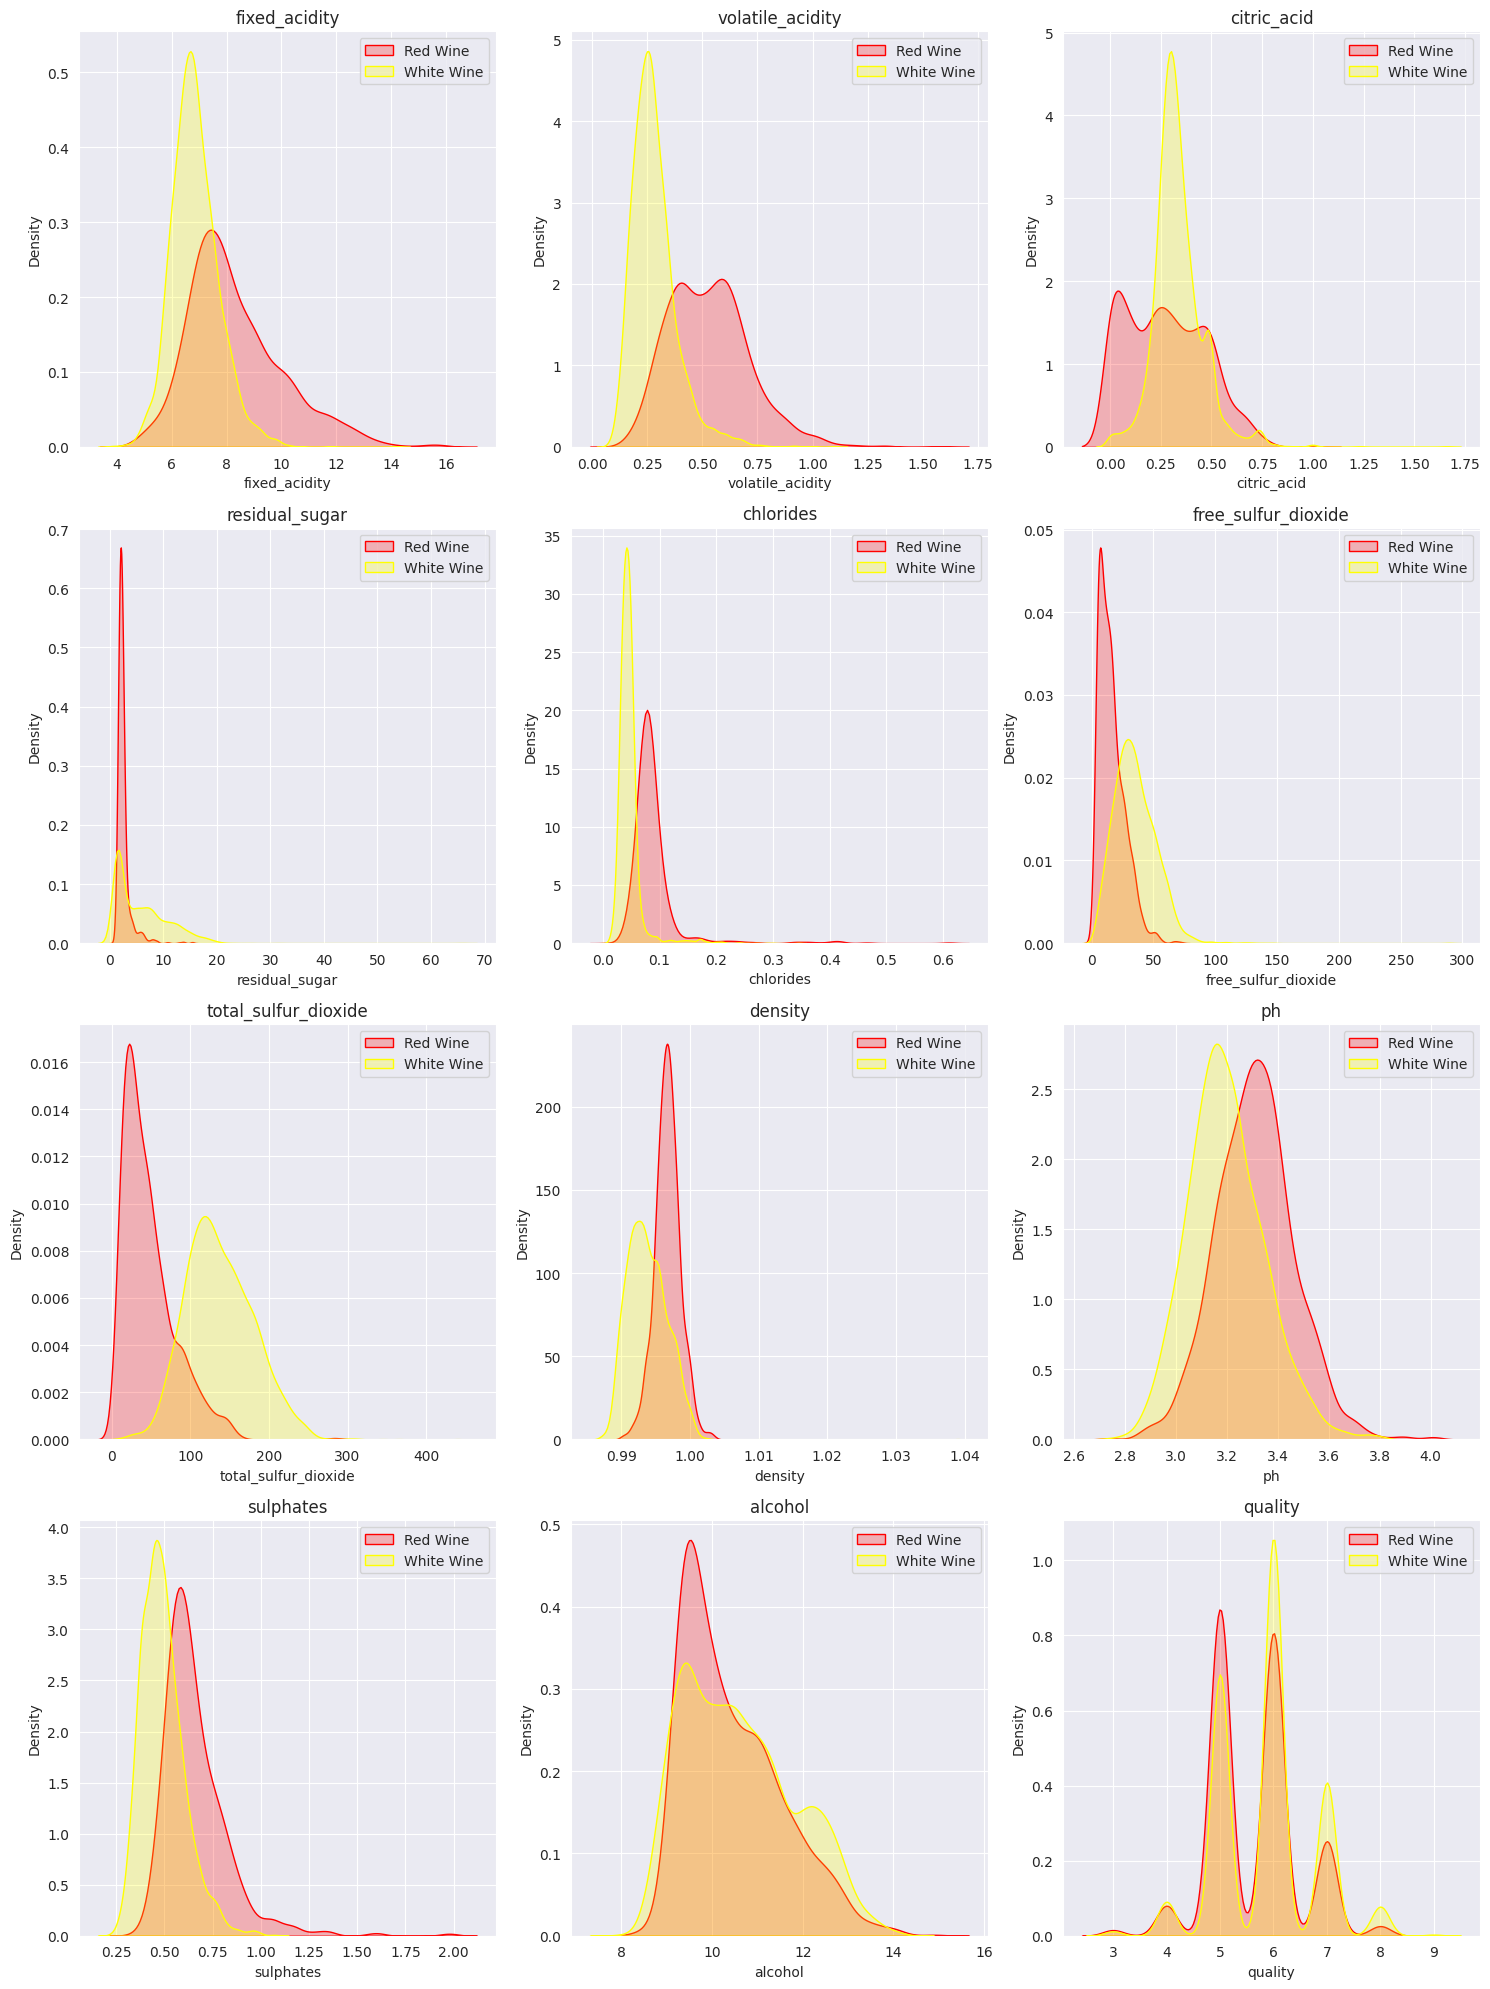

In [19]:
rows = 4
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(red_wine_df_cleaned.columns):
    sns.kdeplot(red_wine_df_cleaned[feature], fill=True, color='red', label='Red Wine', ax=axes[i])
    sns.kdeplot(white_wine_df_cleaned[feature], fill=True, color='yellow', label='White Wine', ax=axes[i])
    #sns.kdeplot(all_wine_df_cleaned[feature], fill=True, color='purple', label='All Wine', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

## Averages to see how different white and red wines are

In [20]:
avg_red_wine = red_wine_df_cleaned.mean()
avg_white_wine = white_wine_df_cleaned.mean()
avg_comparison = pd.DataFrame({'Red Wine': avg_red_wine, 'White Wine': avg_white_wine})
print("\nAverage Values Comparison:\n", avg_comparison)


Average Values Comparison:
                        Red Wine  White Wine
fixed_acidity          8.310596    6.839346
volatile_acidity       0.529478    0.280538
citric_acid            0.272333    0.334332
residual_sugar         2.523400    5.914819
chlorides              0.088124    0.045905
free_sulfur_dioxide   15.893304   34.889169
total_sulfur_dioxide  46.825975  137.193512
density                0.996709    0.993790
ph                     3.309787    3.195458
sulphates              0.658705    0.490351
alcohol               10.432315   10.589358
quality                5.623252    5.854835


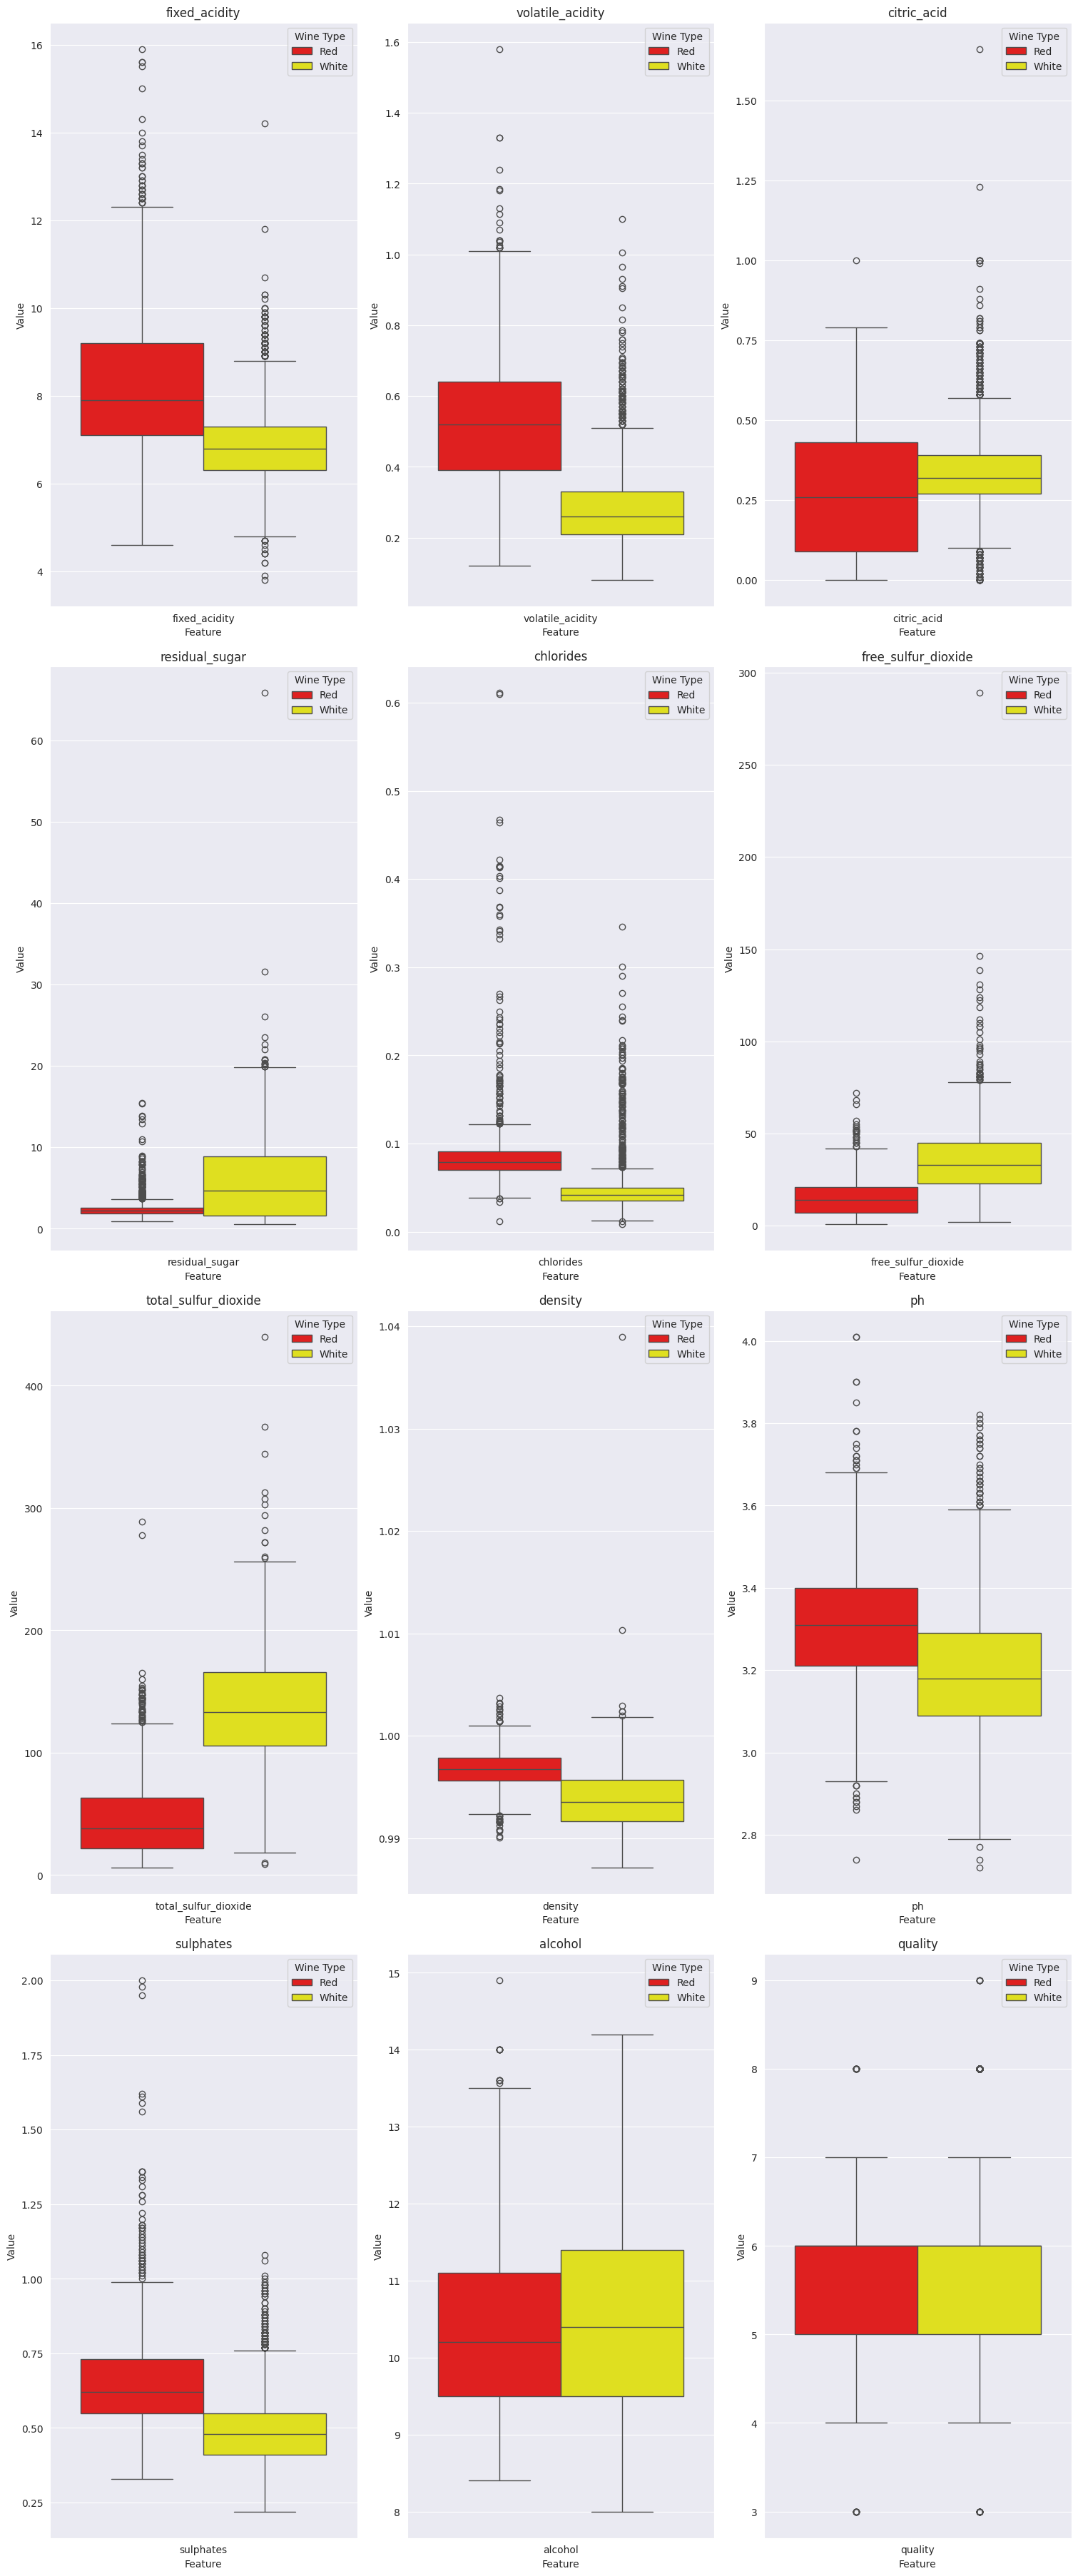

In [21]:
# Melting the DataFrames to long format suitable for sns.boxplot
red_melted = red_wine_df_cleaned.melt(var_name='Feature', value_name='Value')
white_melted = white_wine_df_cleaned.melt(var_name='Feature', value_name='Value')

# Adding a column to distinguish between red and white wine data
red_melted['Wine Type'] = 'Red'
white_melted['Wine Type'] = 'White'

# Combining the two DataFrames
combined_wine = pd.concat([red_melted, white_melted])

# Determine the number of unique features to create subplots
num_features = len(red_wine_df_cleaned.columns)

# Create a figure and axes for the subplots with 3 boxplots per row
fig, axes = plt.subplots(nrows=int(np.ceil(num_features / 3)), ncols=3, figsize=(15, num_features * 3), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting the boxplot for each feature on its own subplot
for i, feature in enumerate(red_wine_df_cleaned.columns):
    sns.boxplot(x='Feature', y='Value', hue='Wine Type', data=combined_wine[combined_wine['Feature'] == feature], ax=axes[i], palette=['red', 'yellow'])
    axes[i].set_title(feature)

# Hide any unused axes if the number of features is odd
if num_features % 3 != 0:
    axes[-1].set_visible(False)

plt.show()

From the data above it seems that it is a good idea to keep the white and red wines separated when analyzing.

## Try the pairplot used in the previous exercise.

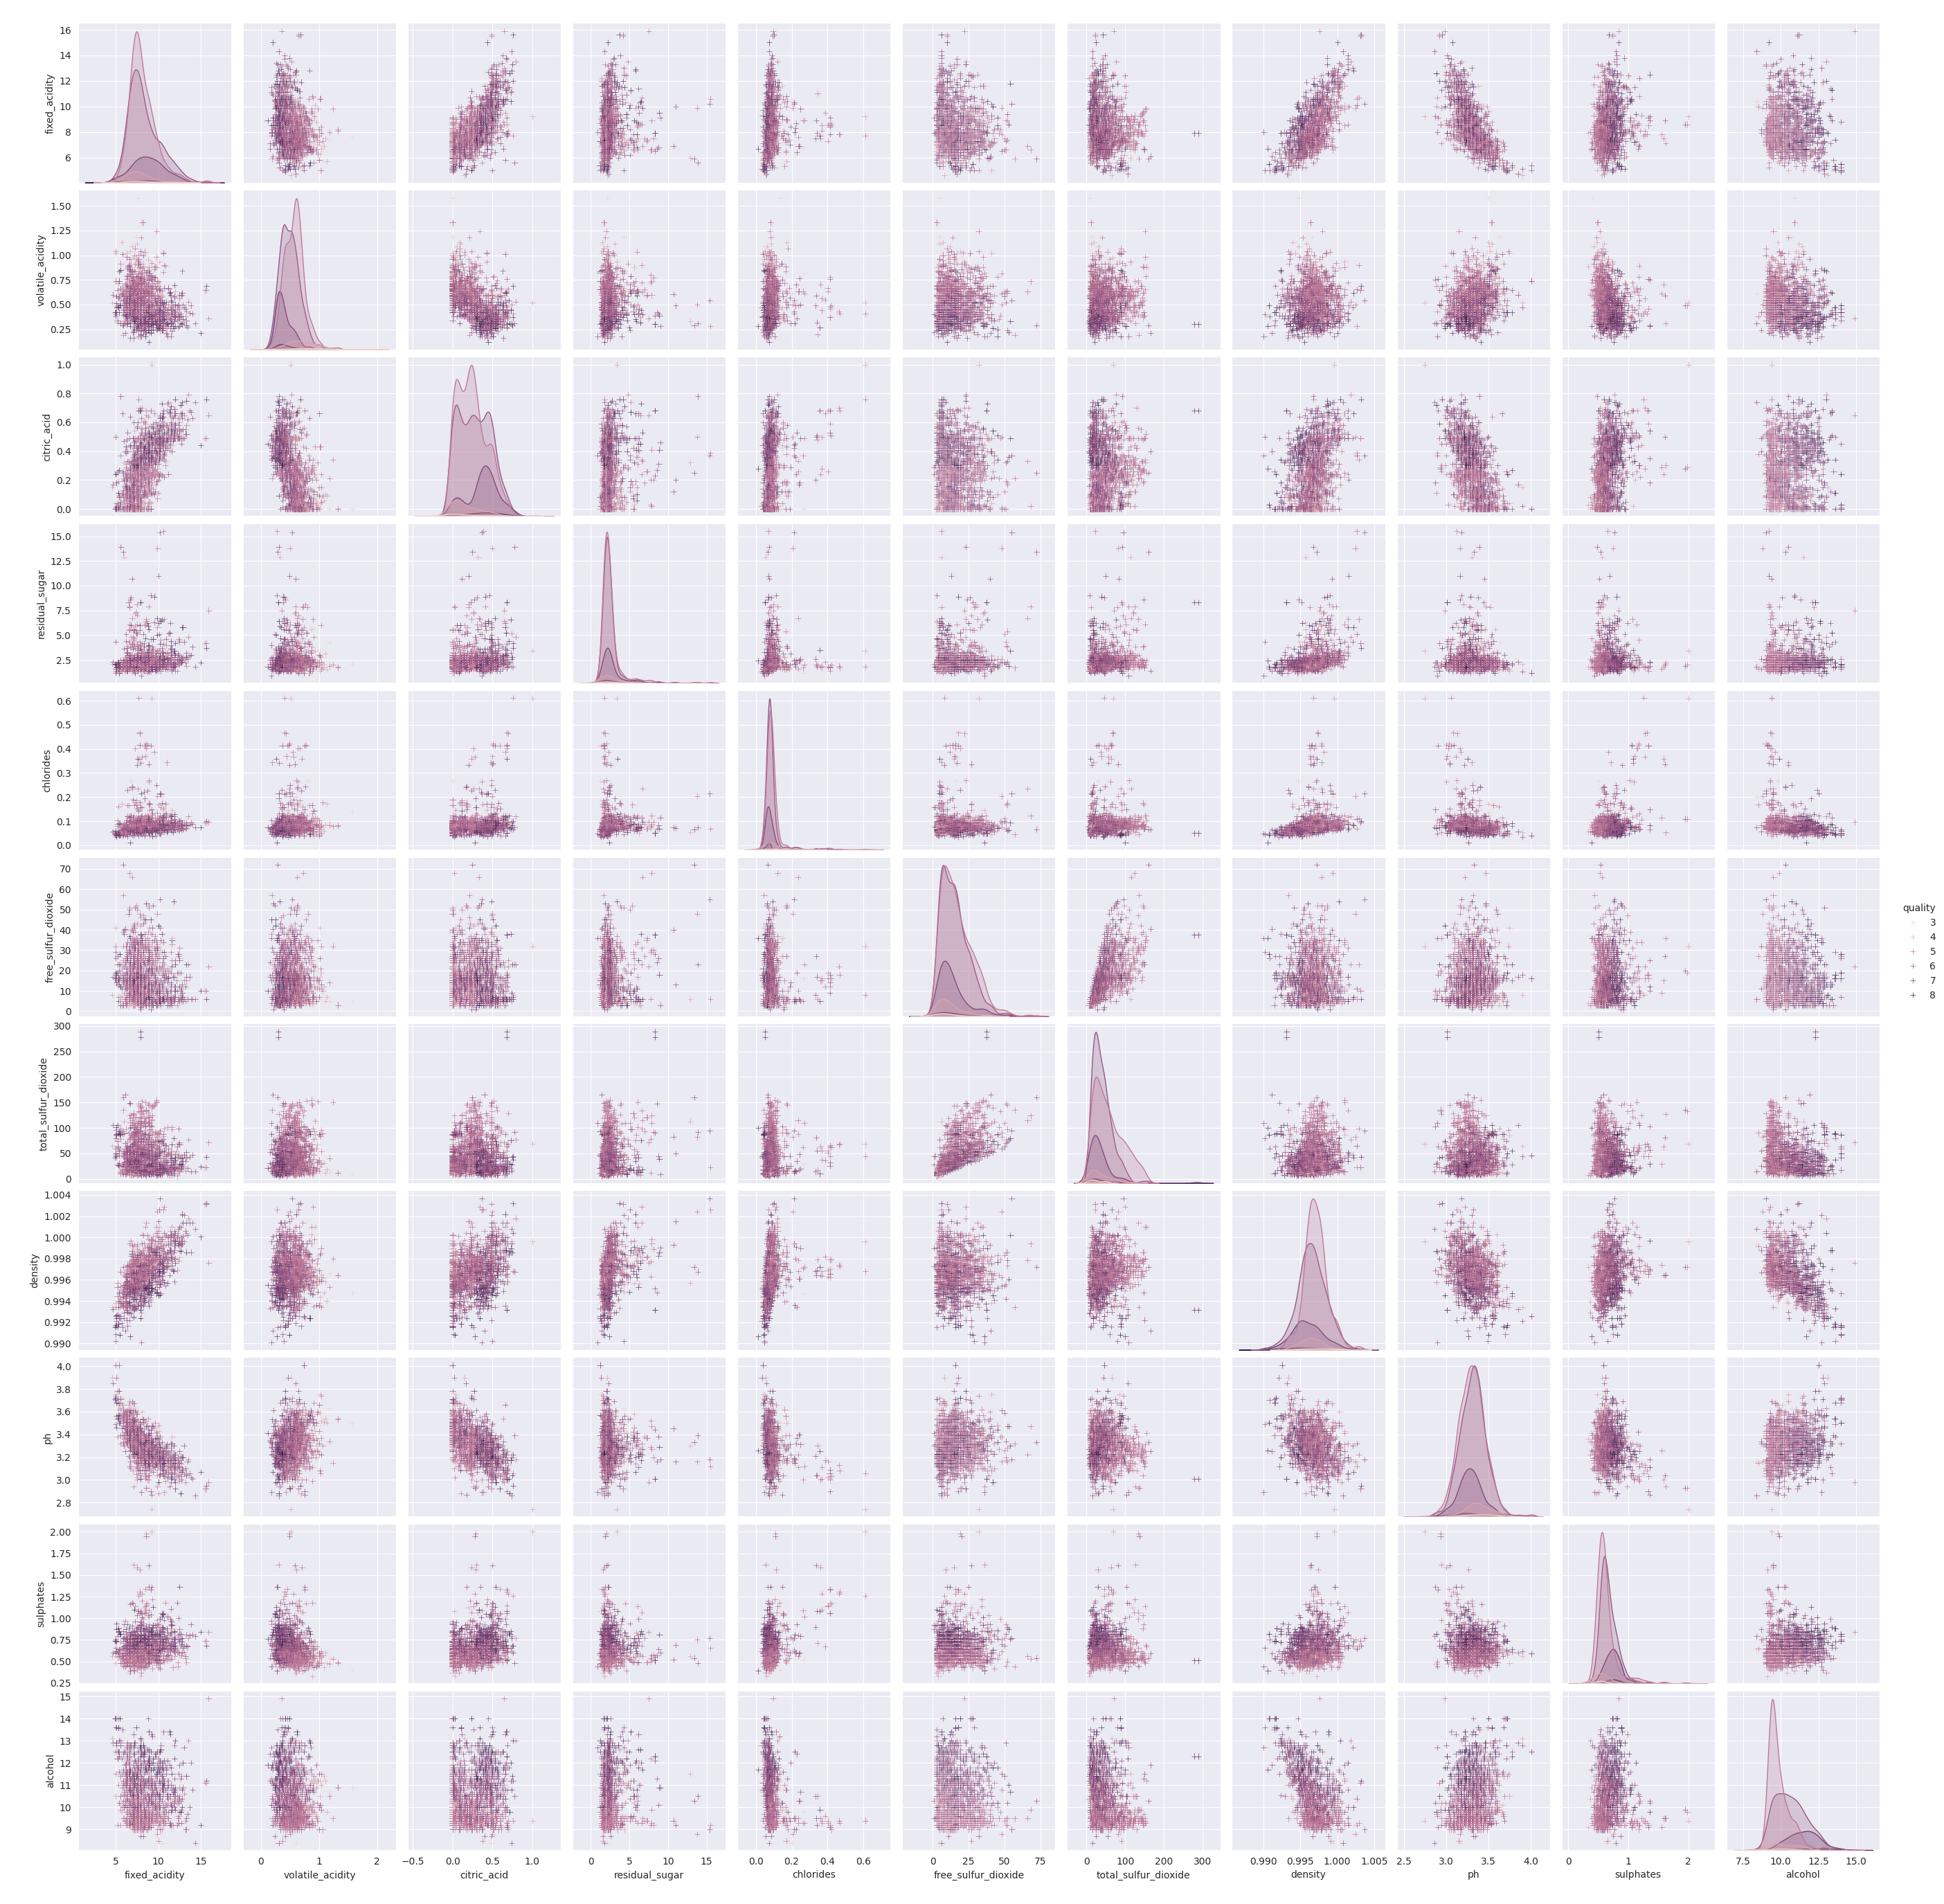

In [22]:
def plot_fn_wine_red_pairplot():
    sns.pairplot(red_wine_df_cleaned, hue='quality', markers='+')
    
plot_or_cache(plot_fn_wine_red_pairplot, "red_wine_df_cleaned_pairplot")

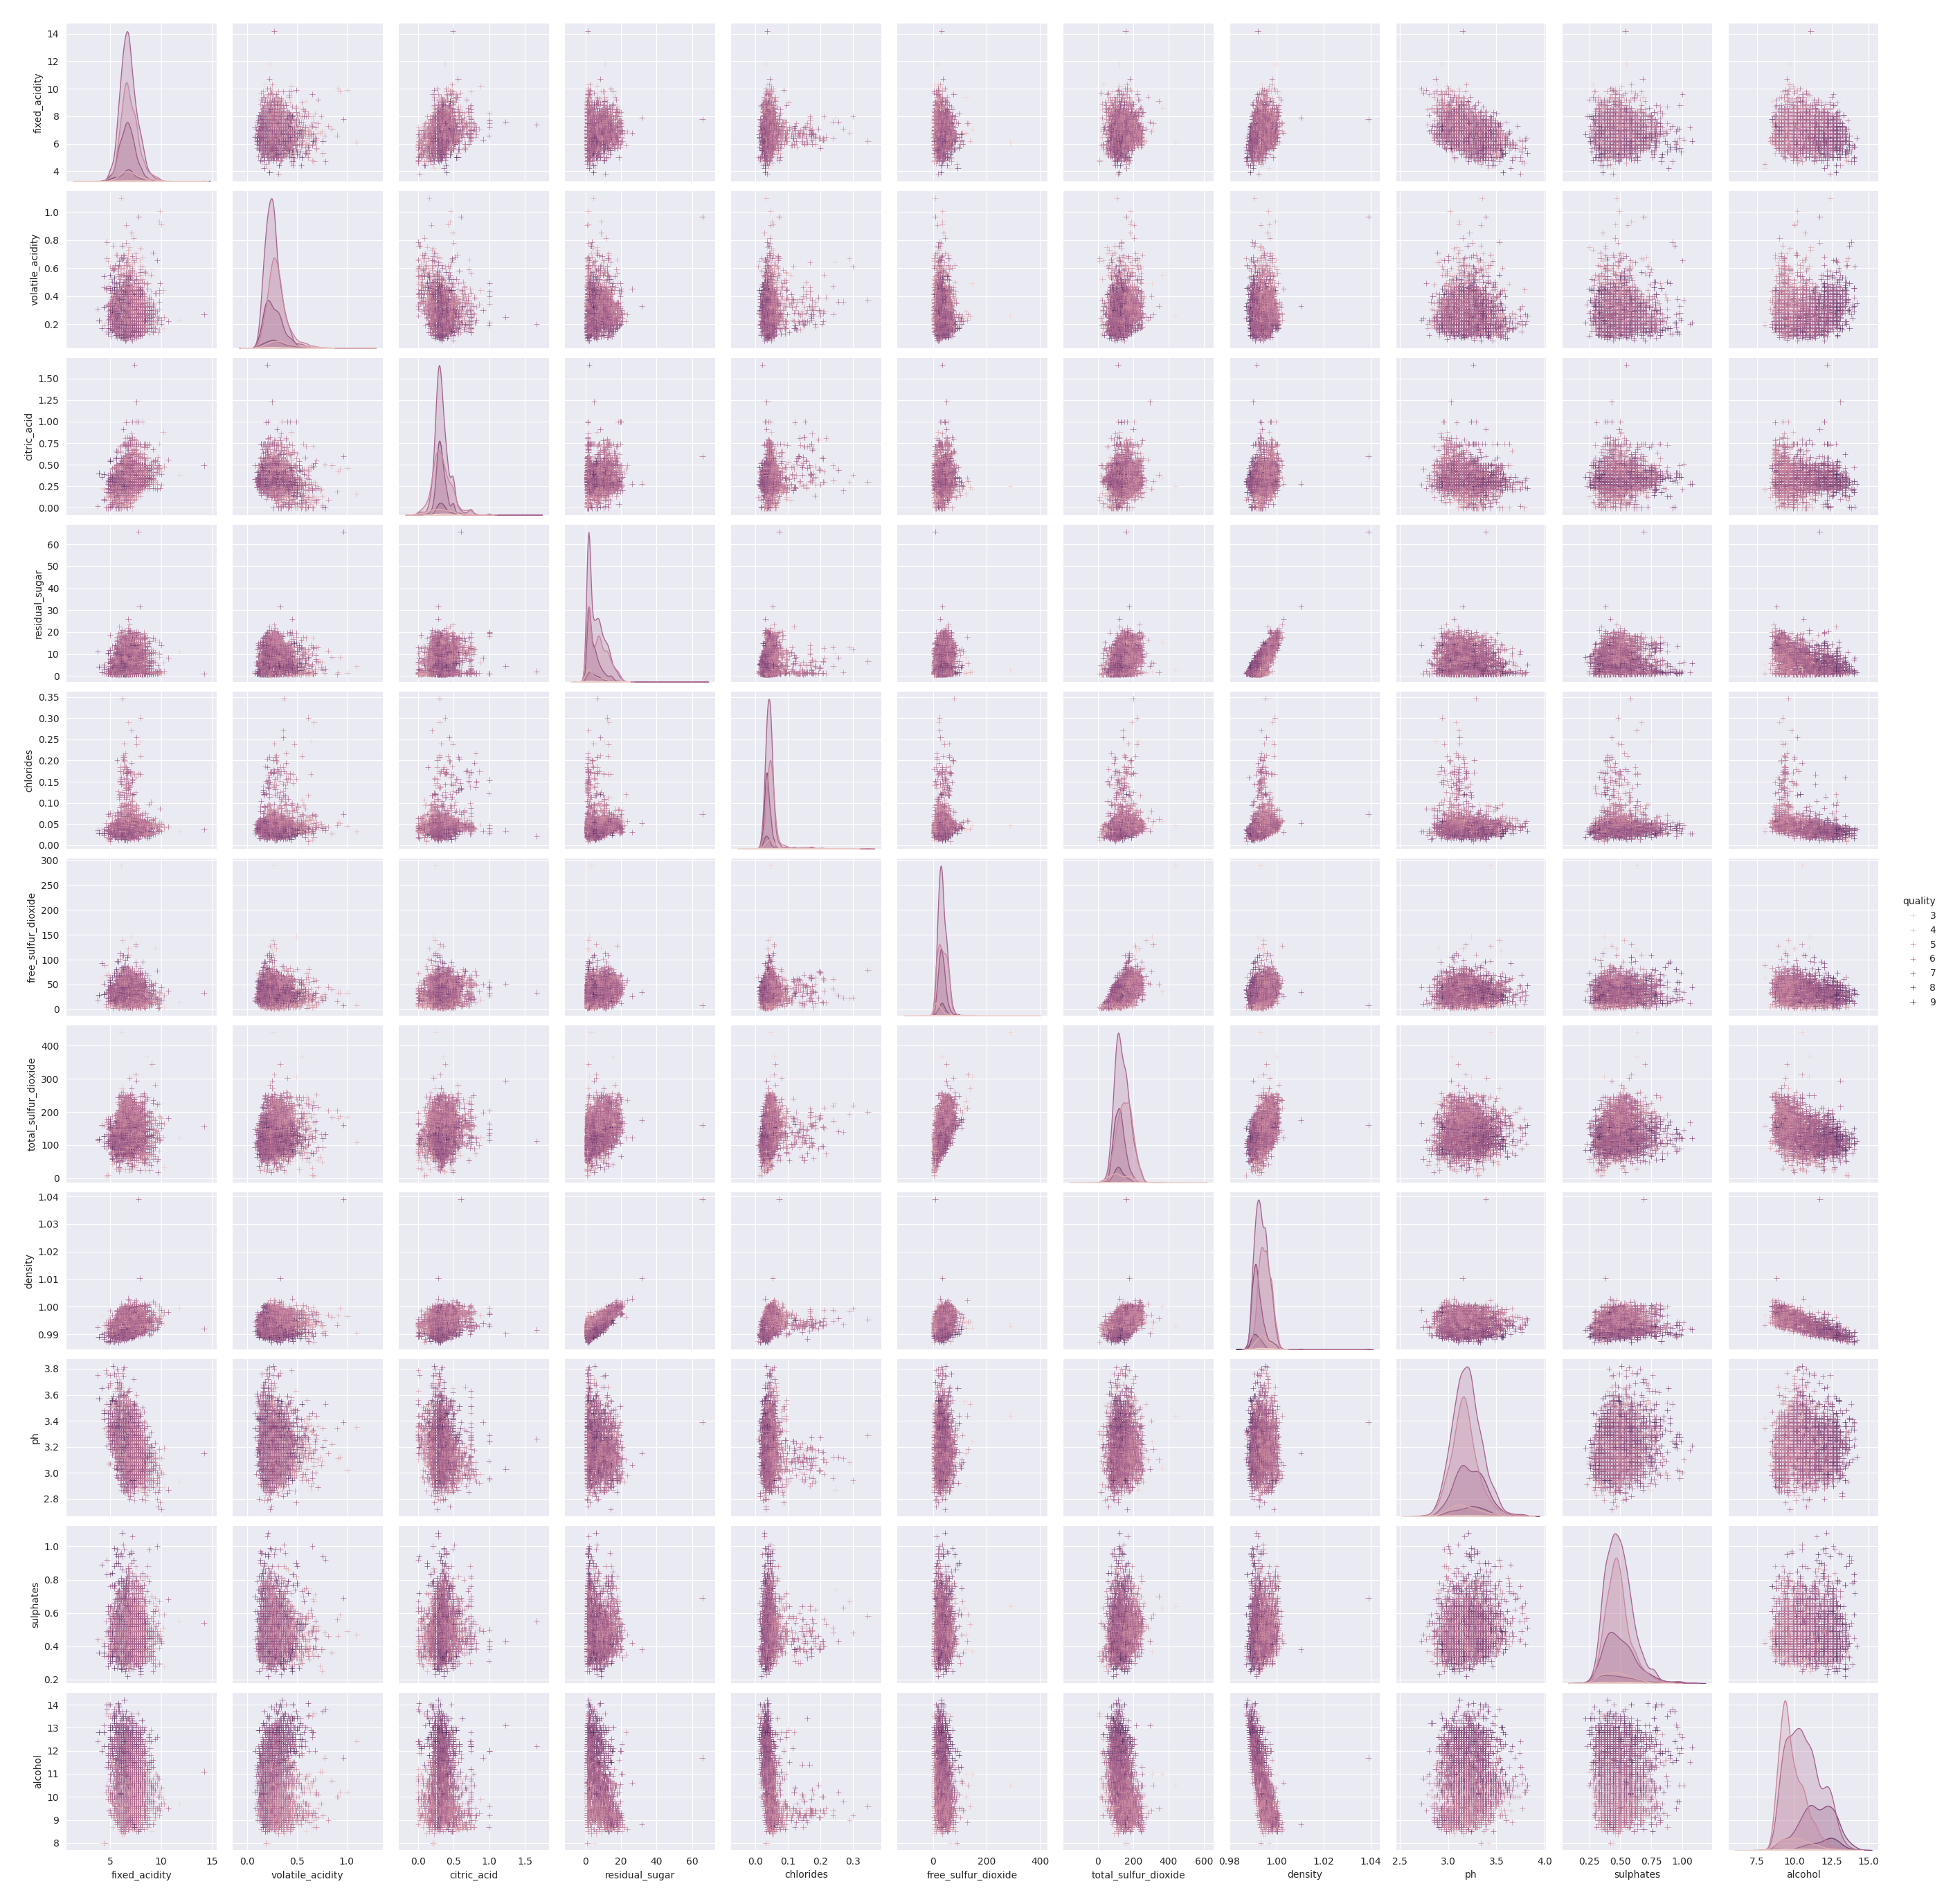

In [23]:
def plot_fn_wine_white_pairplot():
    sns.pairplot(white_wine_df_cleaned, hue='quality', markers='+')
    
plot_or_cache(plot_fn_wine_white_pairplot, "white_wine_df_cleaned_pairplot")

It is very difficult to draw any conclusions from the above data. The data is very dense and from looking at the distributions it only looks like alcohol is somewhat separable.

## Hexbin and 2D density plot
Just testing... It didn't give me much

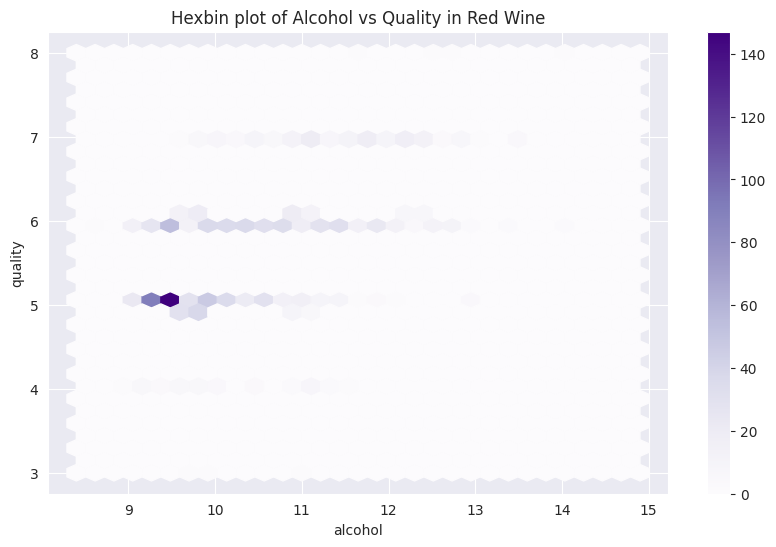

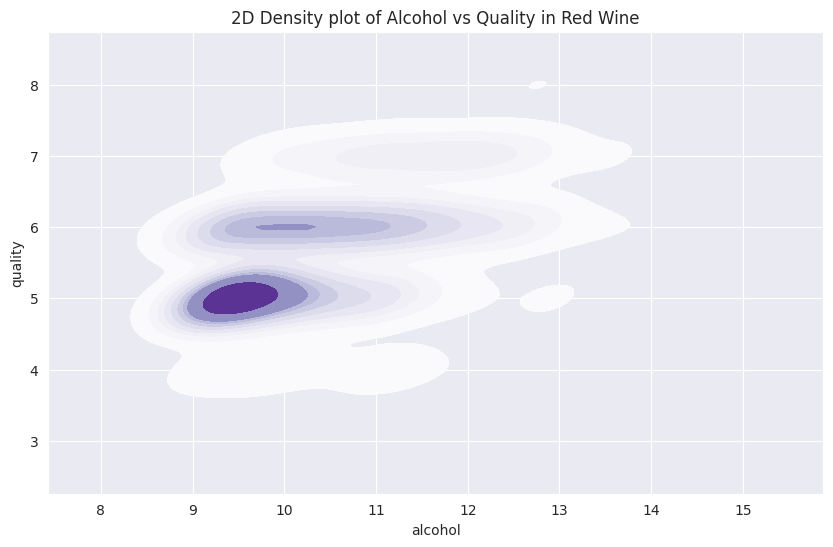

In [24]:
# Choosing features to compare
feature_x = 'alcohol'
feature_y = 'quality'

plt.figure(figsize=(10, 6))
plt.hexbin(red_wine_df_cleaned[feature_x], red_wine_df_cleaned[feature_y], gridsize=30, cmap='Purples')
plt.colorbar()
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title('Hexbin plot of Alcohol vs Quality in Red Wine')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=red_wine_df_cleaned, x=feature_x, y=feature_y, cmap="Purples", fill=True)
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title('2D Density plot of Alcohol vs Quality in Red Wine')
plt.show()

## Violin plot

2023-11-19 18:47:52,625 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-19 18:47:52,631 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


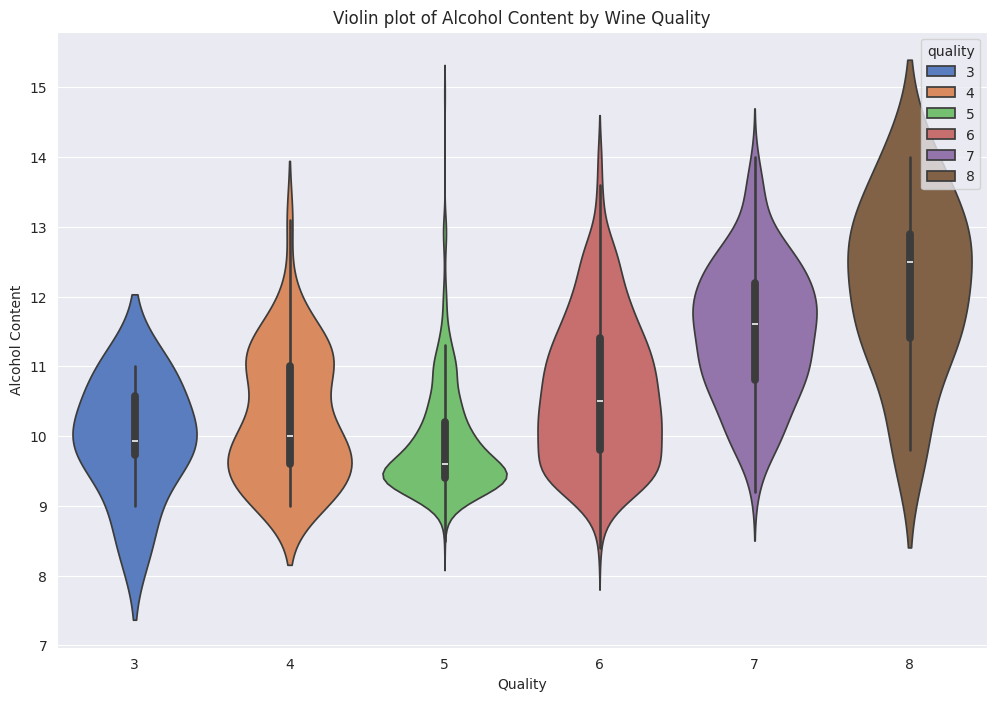

2023-11-19 18:47:52,900 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-19 18:47:52,913 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


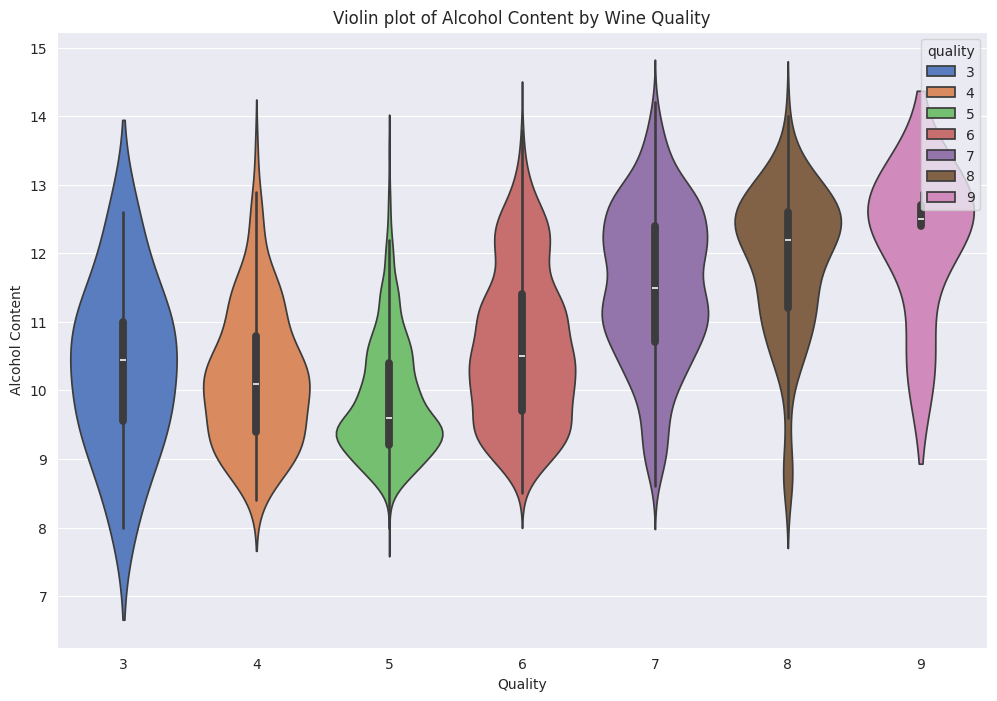

In [25]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='quality', hue='quality', y='alcohol', data=red_wine_df_cleaned, palette='muted')
plt.title('Violin plot of Alcohol Content by Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Alcohol Content')
plt.show()

plt.figure(figsize=(12, 8))
sns.violinplot(x='quality', hue='quality', y='alcohol', data=white_wine_df_cleaned, palette='muted')
plt.title('Violin plot of Alcohol Content by Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Alcohol Content')
plt.show()

In [26]:
# Calculate the IQR based bounds for the violin plots
def calculate_iqr_bounds(df, feature):
    # Calculate Q1 and Q3
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    # Calculate the IQR
    IQR = Q3 - Q1
    # Define the bounds with a 1.5 * IQR buffer to handle outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

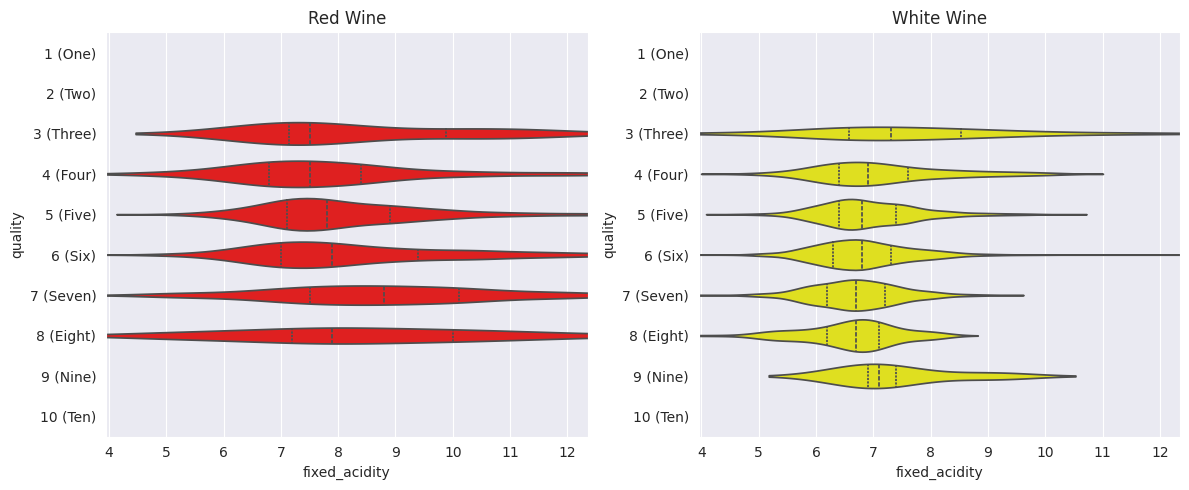

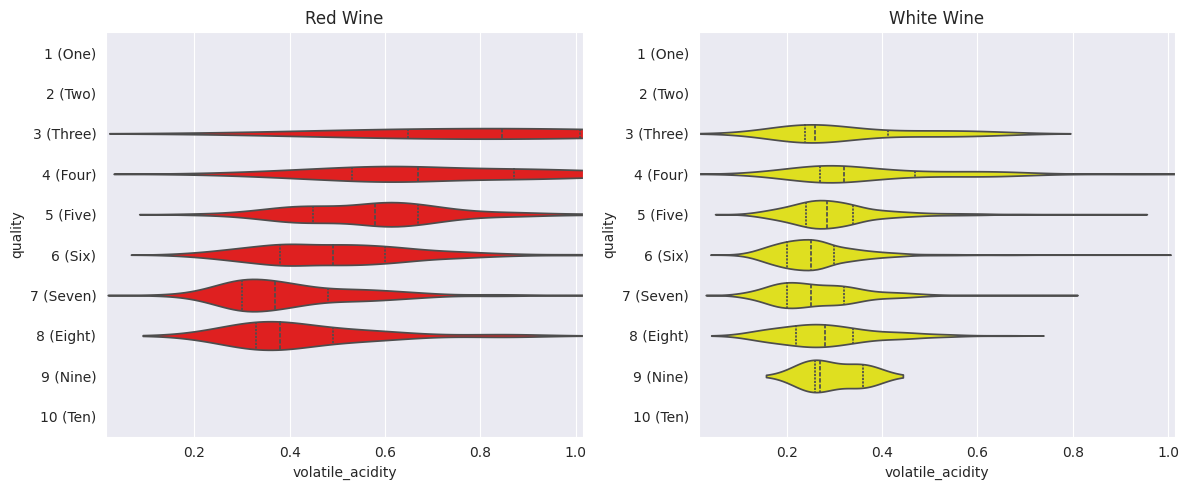

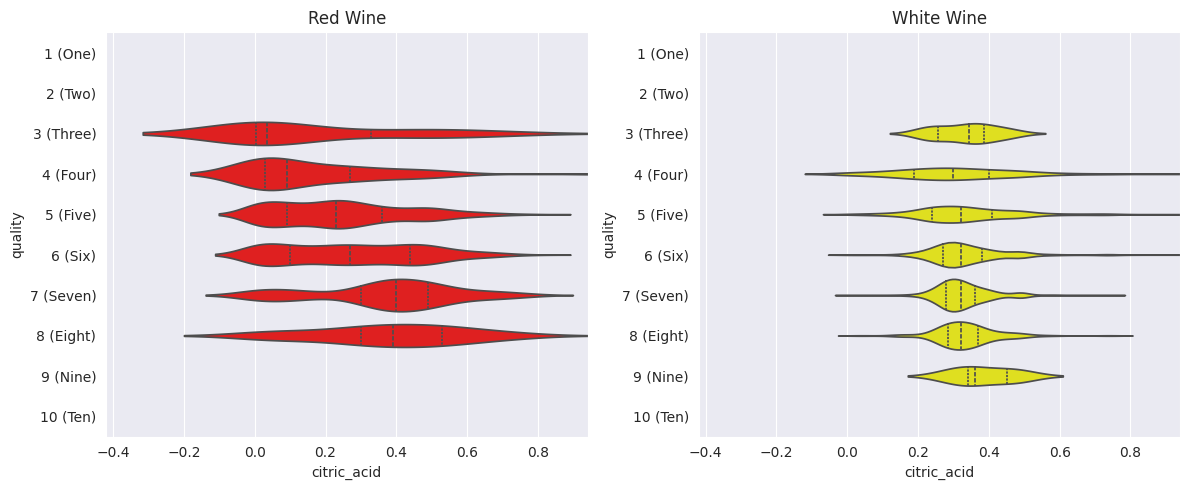

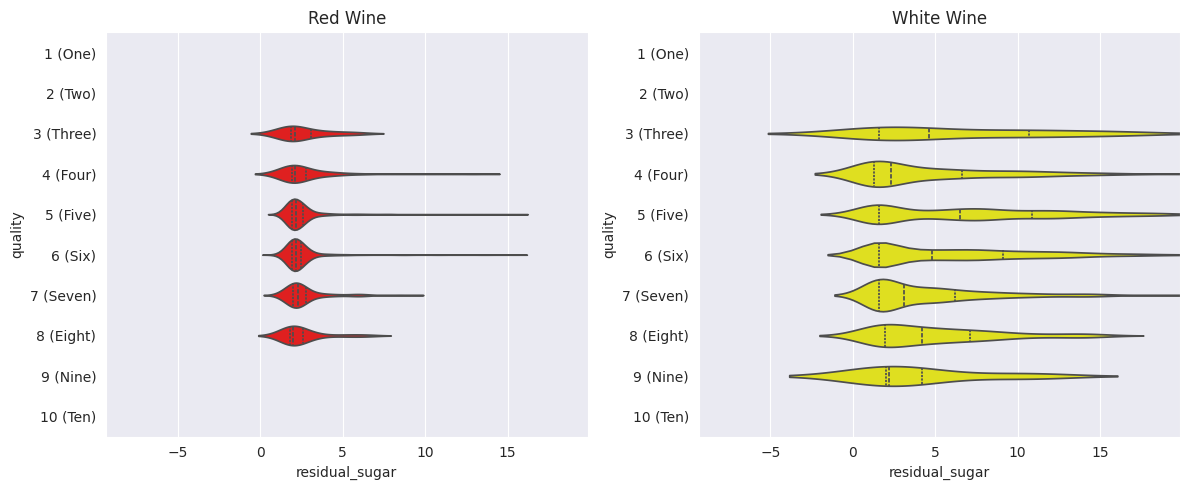

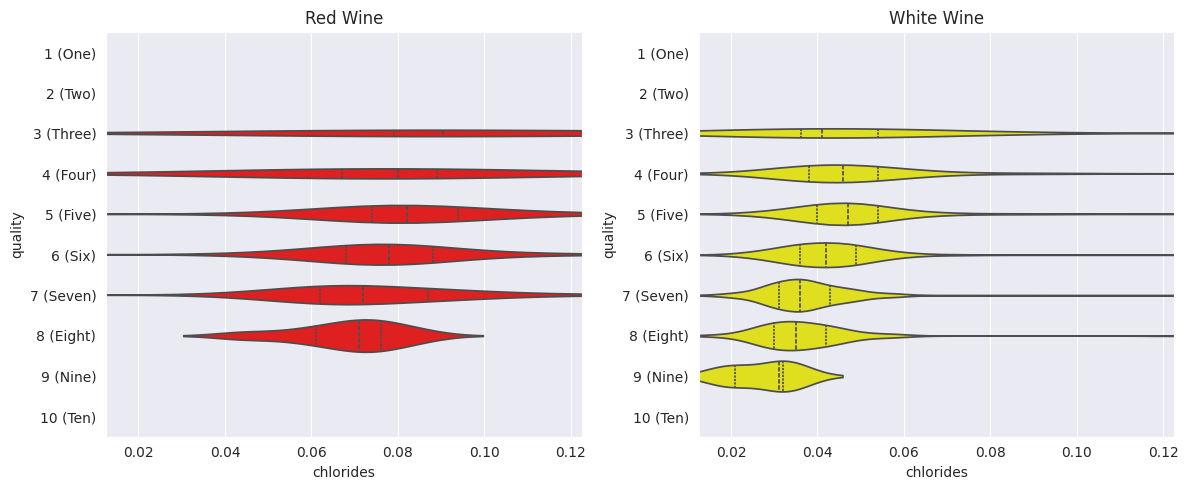

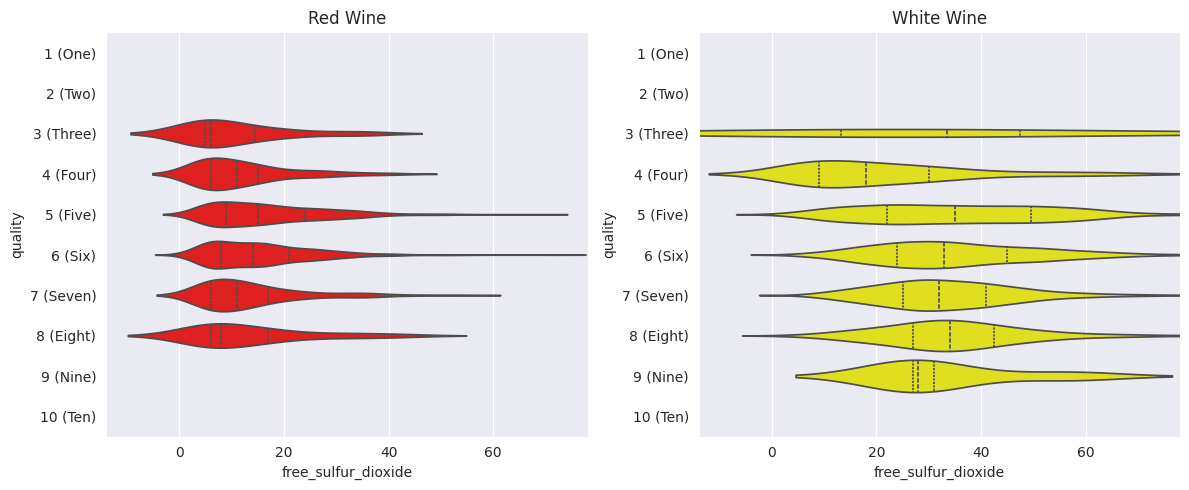

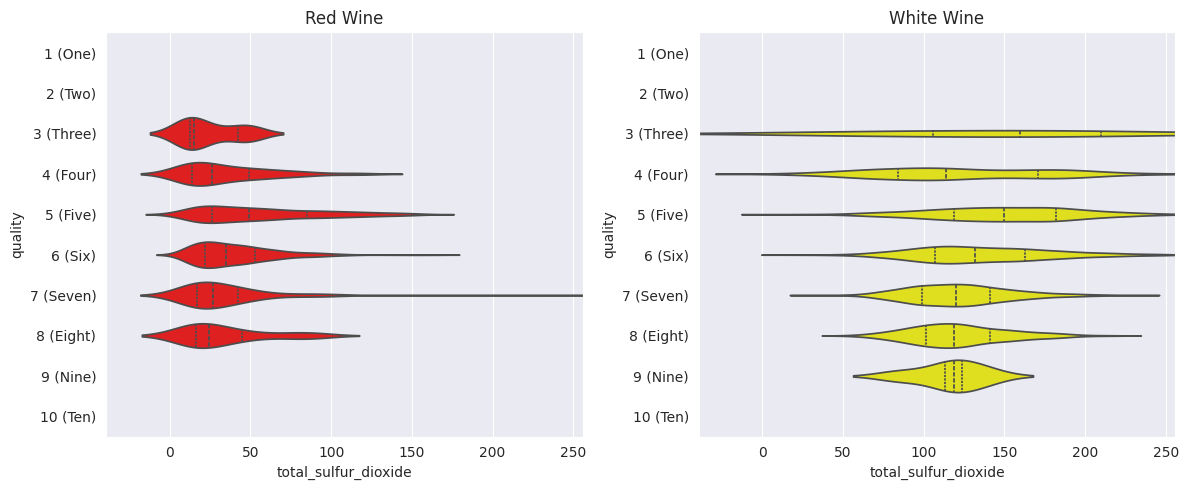

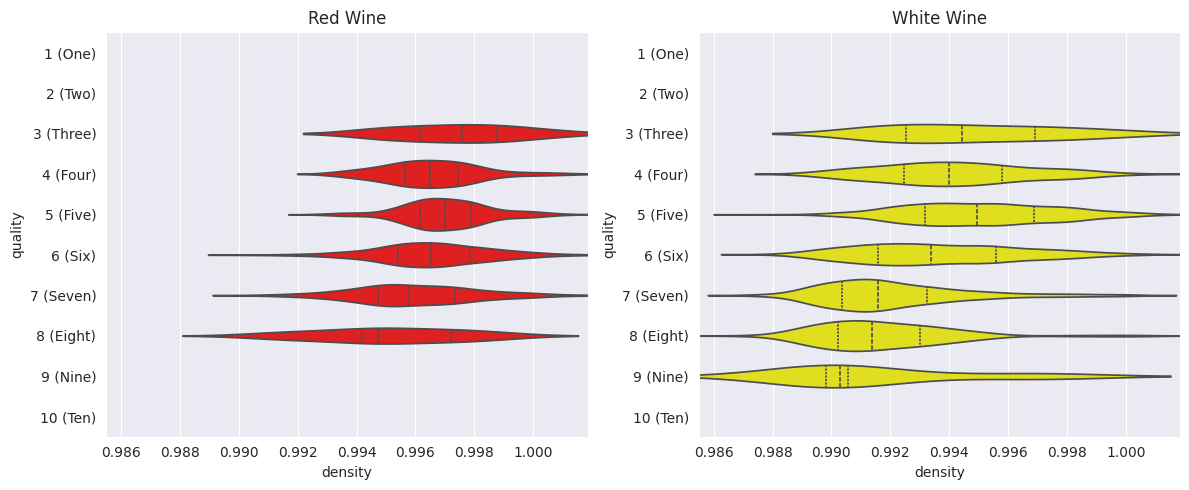

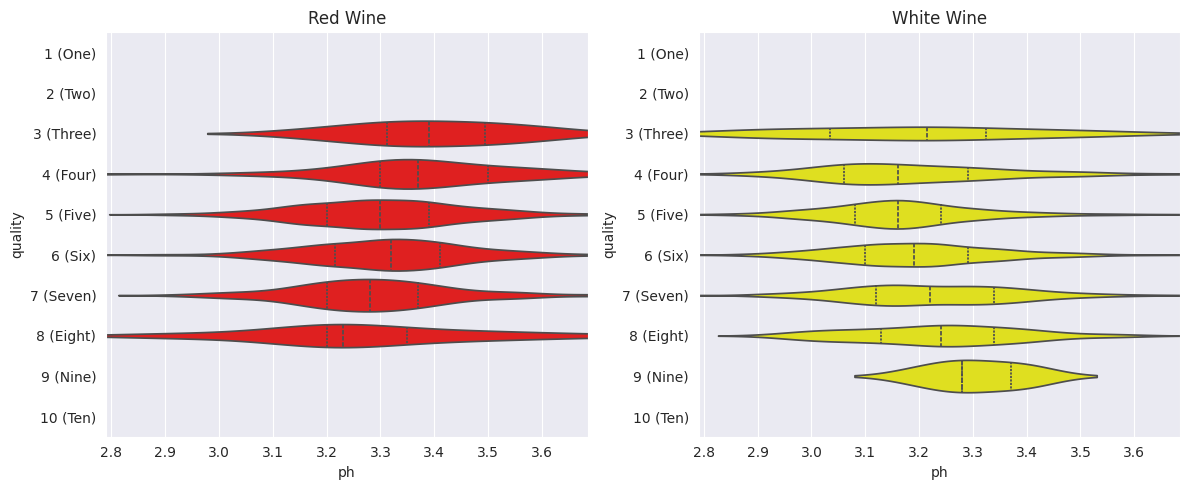

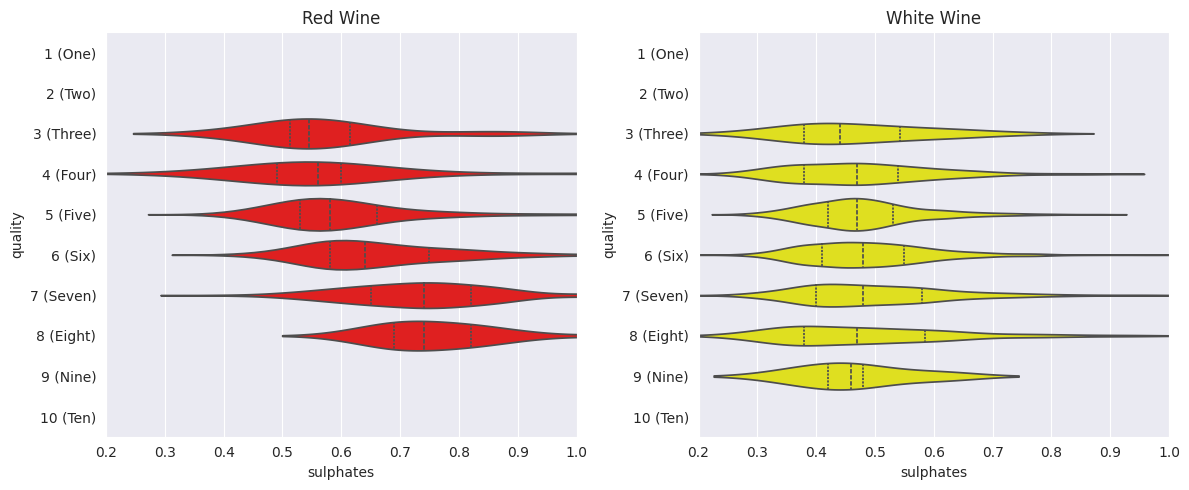

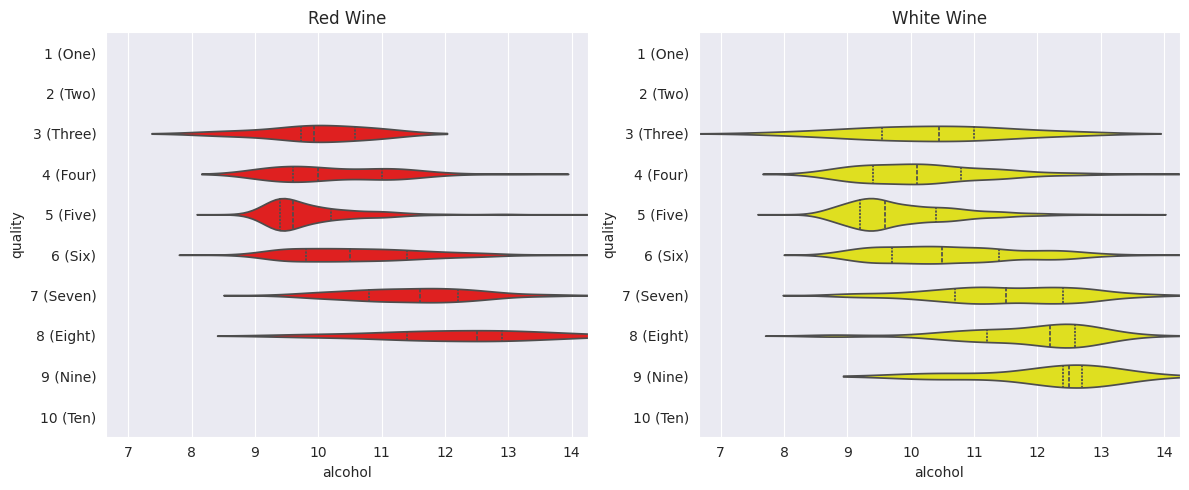

In [27]:
# Categorical Type
red_wine_df_cleaned_categorical_quality = red_wine_df_cleaned.copy(deep=True)
white_wine_df_cleaned_categorical_quality = white_wine_df_cleaned.copy(deep=True)

quality_mapping = {
    1: '1 (One)',
    2: '2 (Two)',
    3: '3 (Three)',
    4: '4 (Four)',
    5: '5 (Five)',
    6: '6 (Six)',
    7: '7 (Seven)',
    8: '8 (Eight)',
    9: '9 (Nine)',
    10: '10 (Ten)'
}

red_wine_df_cleaned_categorical_quality['quality'] = red_wine_df_cleaned_categorical_quality['quality'].map(quality_mapping)
white_wine_df_cleaned_categorical_quality['quality'] = white_wine_df_cleaned_categorical_quality['quality'].map(quality_mapping)

# Plot next to each other
desired_quality_order = [quality_mapping[quality_mapping_key] for quality_mapping_key in quality_mapping]

# Create a new categorical variable for "quality" with the desired order
red_wine_df_cleaned_categorical_quality['quality'] = pd.Categorical(red_wine_df_cleaned_categorical_quality['quality'], categories=desired_quality_order, ordered=True)
white_wine_df_cleaned_categorical_quality['quality'] = pd.Categorical(white_wine_df_cleaned_categorical_quality['quality'], categories=desired_quality_order, ordered=True)

for feature in list(red_wine_df_cleaned.columns)[:-1]:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Calculate IQR based bounds for both red and white wine datasets
    lower_red, upper_red = calculate_iqr_bounds(red_wine_df_cleaned, feature)
    lower_white, upper_white = calculate_iqr_bounds(white_wine_df_cleaned, feature)
    
    # Setting a common range for both plots with some buffer
    min_value = min(lower_red, lower_white)
    max_value = max(upper_red, upper_white)
    
    sns.violinplot(y='quality', x=feature, data=red_wine_df_cleaned_categorical_quality, 
                   inner='quartile', color='red', ax=axes[0])
    sns.violinplot(y='quality', x=feature, data=white_wine_df_cleaned_categorical_quality, 
                   inner='quartile', color='yellow', ax=axes[1])
    
    # Setting the same x-axis limits for both plots
    axes[0].set_xlim(min_value, max_value)
    axes[1].set_xlim(min_value, max_value)
    
    axes[0].set_title('Red Wine')
    axes[1].set_title('White Wine')
    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the plots
    plt.show()

Cannot make any new conclusions from the above plot only that the quality ratings appear similar. Otherwise they present quite different qualities.

# Feature selection

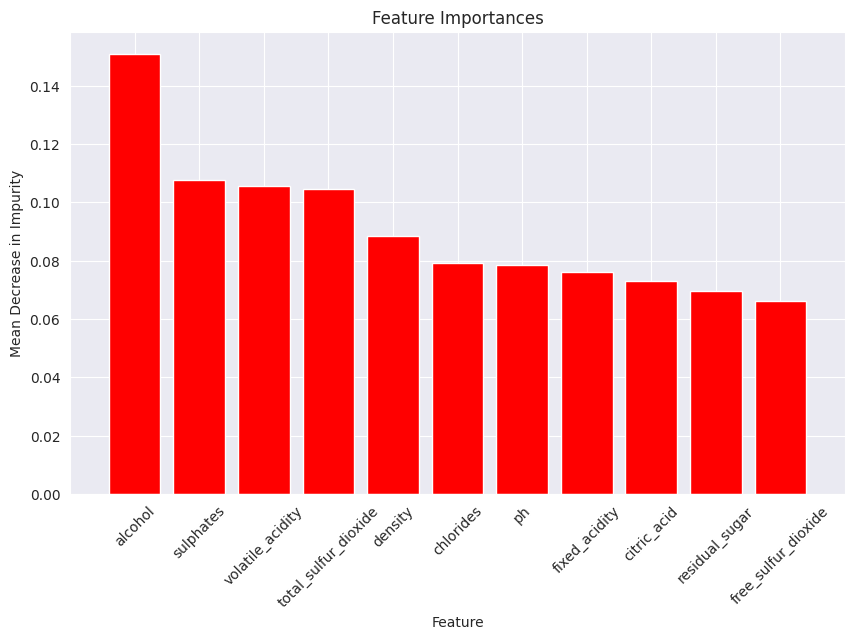

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol'],
      dtype='object')
Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol'],
      dtype='object')


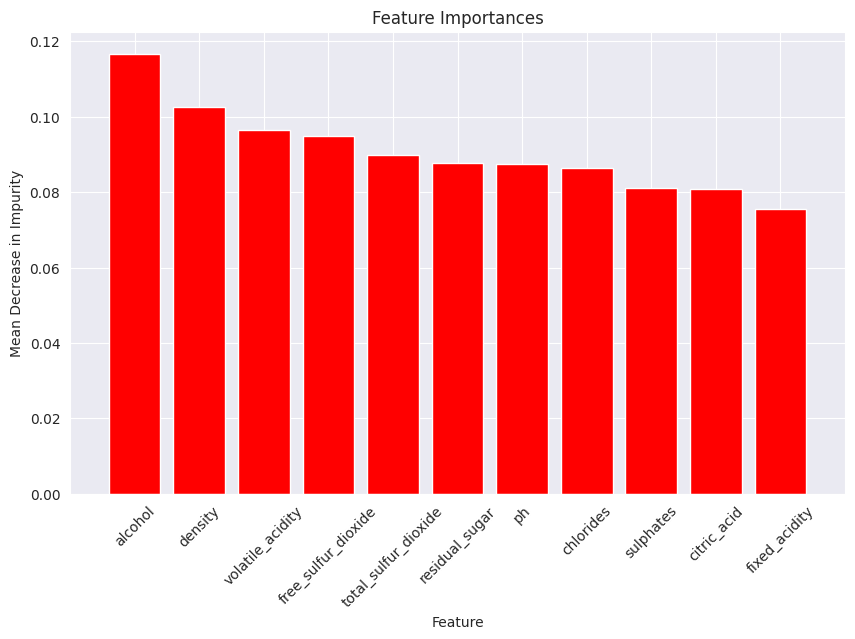

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol'],
      dtype='object')
Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol'],
      dtype='object')


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

def plot_feature_importances(df, target_column='quality'):
    # Separate features and target variable
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Train the model
    model = RandomForestClassifier()
    model.fit(X, y)

    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
    plt.xlim([-1, X.shape[1]])
    plt.xlabel("Feature")
    plt.ylabel("Mean Decrease in Impurity")
    plt.show()
    
    # Selecting the important features
    sfm = SelectFromModel(model, threshold=0.05)
    sfm.fit(X, y)
    selected_features = X.columns[(sfm.get_support())]
    
    # Could any be dropped?
    print(red_wine_df_cleaned.drop('quality', axis=1).columns)
    print(selected_features)

plot_feature_importances(red_wine_df_cleaned)
plot_feature_importances(white_wine_df_cleaned)

No features could be dropped... So let's keep all

# Correlation Matrix

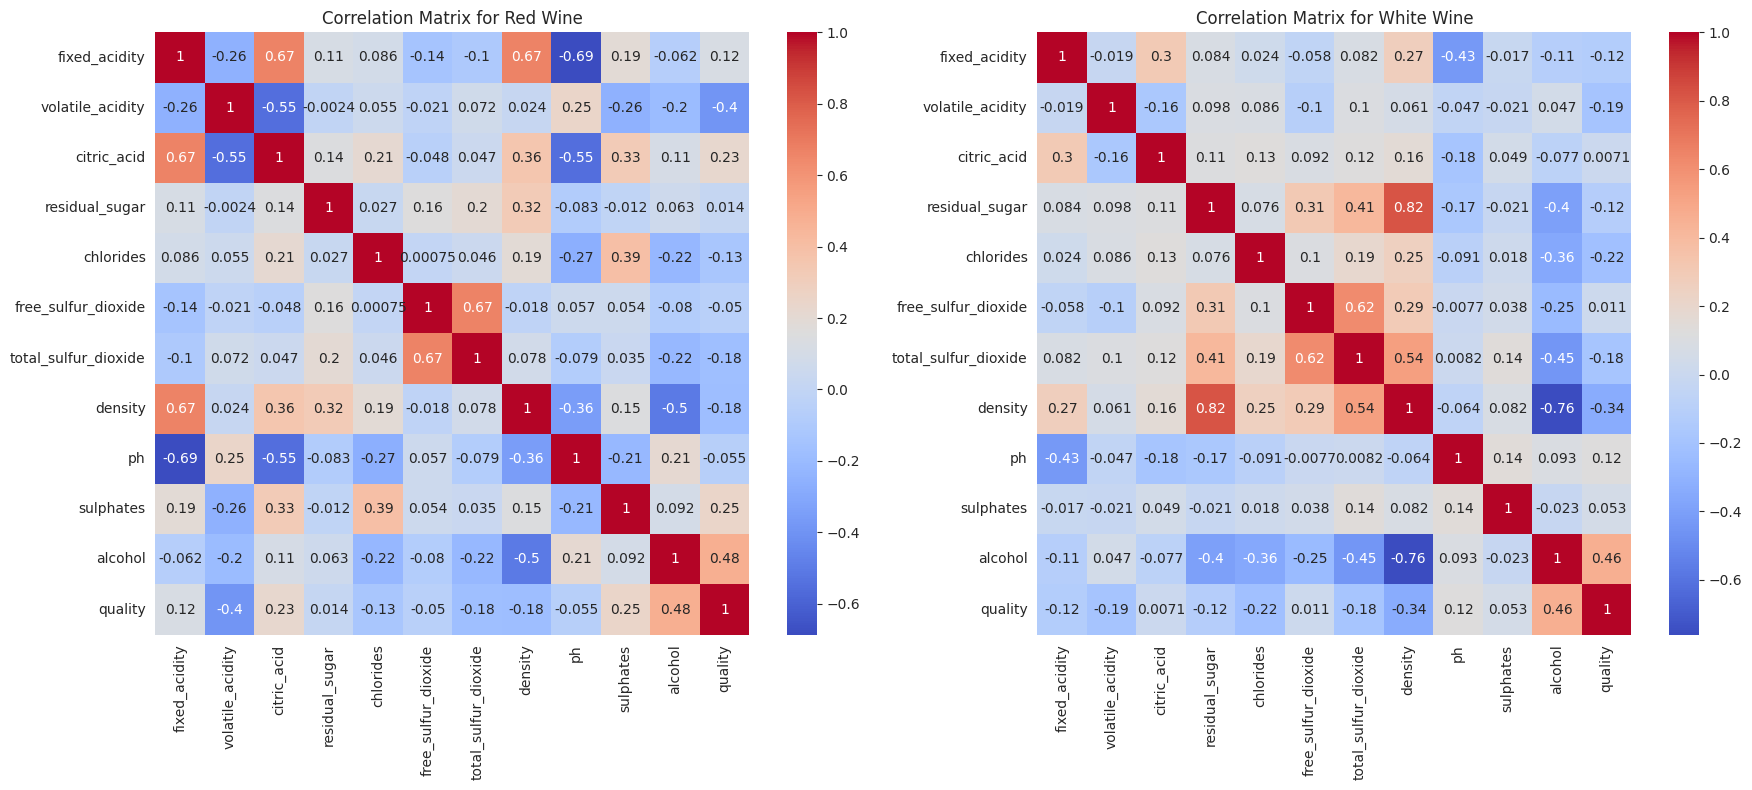

In [29]:
# Generate correlation matrices
corr_matrix_red = red_wine_df_cleaned.corr()
corr_matrix_white = white_wine_df_cleaned.corr()

# Plotting the correlation matrices using heatmaps
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix_red, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Red Wine')

plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix_white, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for White Wine')

plt.tight_layout()
plt.show()

Quality is definitely an important feature. It is interesting how the correlation between the features change between red and white wines. Density correlates with the rest of the features very differently in the white whine than in the red wine. 

# Insert (backfill) red and white wine historical data separately
It seems that it is best to train two different models, one for the red wine data and one for the white wine.

In [31]:
# Add types
red_wine_df_cleaned_with_type = red_wine_df_cleaned.copy(deep=True)
red_wine_df_cleaned_with_type["type"] = "red"
red_wine_df_cleaned_with_type = red_wine_df_cleaned_with_type[['type'] + [col for col in red_wine_df_cleaned_with_type if col != 'type']]

white_wine_df_cleaned_with_type = white_wine_df_cleaned.copy(deep=True)
white_wine_df_cleaned_with_type["type"] = "white"
white_wine_df_cleaned_with_type = white_wine_df_cleaned_with_type[['type'] + [col for col in white_wine_df_cleaned_with_type if col != 'type']]

In [32]:
red_wine_df_cleaned_with_type

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0     red            7.4             0.700         0.00             1.9   
1     red            7.8             0.880         0.00             2.6   
2     red            7.8             0.760         0.04             2.3   
3     red           11.2             0.280         0.56             1.9   
5     red            7.4             0.660         0.00             1.8   
...   ...            ...               ...          ...             ...   
1593  red            6.8             0.620         0.08             1.9   
1594  red            6.2             0.600         0.08             2.0   
1595  red            5.9             0.550         0.10             2.2   
1597  red            5.9             0.645         0.12             2.0   
1598  red            6.0             0.310         0.47             3.6   

      chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    ph  \
0         0.076                 11.0                  34.0  0.99780  3.51   
1         0.098                 25.0                  67.0  0.99680  3.20   
2         0.092                 15.0                  54.0  0.99700  3.26   
3         0.075                 17.0                  60.0  0.99800  3.16   
5         0.075                 13.0                  40.0  0.99780  3.51   
...         ...                  ...                   ...      ...   ...   
1593      0.068                 28.0                  38.0  0.99651  3.42   
1594      0.090                 32.0                  44.0  0.99490  3.45   
1595      0.062                 39.0                  51.0  0.99512  3.52   
1597      0.075                 32.0                  44.0  0.99547  3.57   
1598      0.067                 18.0                  42.0  0.99549  3.39   

      sulphates  alcohol  quality  
0          0.56      9.4        5  
1          0.68      9.8        5  
2          0.65      9.8        5  
3          0.58      9.8        6  
5          0.56      9.4        5  
...         ...      ...      ...  
1593       0.82      9.5        6  
1594       0.58     10.5        5  
1595       0.76     11.2        6  
1597       0.71     10.2        5  
1598       0.66     11.0        6  

[1359 rows x 13 columns]

In [33]:
white_wine_df_cleaned_with_type

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0     white            7.0              0.27         0.36            20.7   
1     white            6.3              0.30         0.34             1.6   
2     white            8.1              0.28         0.40             6.9   
3     white            7.2              0.23         0.32             8.5   
6     white            6.2              0.32         0.16             7.0   
...     ...            ...               ...          ...             ...   
4893  white            6.2              0.21         0.29             1.6   
4894  white            6.6              0.32         0.36             8.0   
4895  white            6.5              0.24         0.19             1.2   
4896  white            5.5              0.29         0.30             1.1   
4897  white            6.0              0.21         0.38             0.8   

      chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    ph  \
0         0.045                 45.0                 170.0  1.00100  3.00   
1         0.049                 14.0                 132.0  0.99400  3.30   
2         0.050                 30.0                  97.0  0.99510  3.26   
3         0.058                 47.0                 186.0  0.99560  3.19   
6         0.045                 30.0                 136.0  0.99490  3.18   
...         ...                  ...                   ...      ...   ...   
4893      0.039                 24.0                  92.0  0.99114  3.27   
4894      0.047                 57.0                 168.0  0.99490  3.15   
4895      0.041                 30.0                 111.0  0.99254  2.99   
4896      0.022                 20.0                 110.0  0.98869  3.34   
4897      0.020                 22.0                  98.0  0.98941  3.26   

      sulphates  alcohol  quality  
0          0.45      8.8        6  
1          0.49      9.5        6  
2          0.44     10.1        6  
3          0.40      9.9        6  
6          0.47      9.6        6  
...         ...      ...      ...  
4893       0.50     11.2        6  
4894       0.46      9.6        5  
4895       0.46      9.4        6  
4896       0.38     12.8        7  
4897       0.32     11.8        6  

[3961 rows x 13 columns]

In [34]:
# Combine
wine_all_df = pd.concat([red_wine_df_cleaned_with_type, white_wine_df_cleaned_with_type])
wine_all_df

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0       red            7.4              0.70         0.00             1.9   
1       red            7.8              0.88         0.00             2.6   
2       red            7.8              0.76         0.04             2.3   
3       red           11.2              0.28         0.56             1.9   
5       red            7.4              0.66         0.00             1.8   
...     ...            ...               ...          ...             ...   
4893  white            6.2              0.21         0.29             1.6   
4894  white            6.6              0.32         0.36             8.0   
4895  white            6.5              0.24         0.19             1.2   
4896  white            5.5              0.29         0.30             1.1   
4897  white            6.0              0.21         0.38             0.8   

      chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    ph  \
0         0.076                 11.0                  34.0  0.99780  3.51   
1         0.098                 25.0                  67.0  0.99680  3.20   
2         0.092                 15.0                  54.0  0.99700  3.26   
3         0.075                 17.0                  60.0  0.99800  3.16   
5         0.075                 13.0                  40.0  0.99780  3.51   
...         ...                  ...                   ...      ...   ...   
4893      0.039                 24.0                  92.0  0.99114  3.27   
4894      0.047                 57.0                 168.0  0.99490  3.15   
4895      0.041                 30.0                 111.0  0.99254  2.99   
4896      0.022                 20.0                 110.0  0.98869  3.34   
4897      0.020                 22.0                  98.0  0.98941  3.26   

      sulphates  alcohol  quality  
0          0.56      9.4        5  
1          0.68      9.8        5  
2          0.65      9.8        5  
3          0.58      9.8        6  
5          0.56      9.4        5  
...         ...      ...      ...  
4893       0.50     11.2        6  
4894       0.46      9.6        5  
4895       0.46      9.4        6  
4896       0.38     12.8        7  
4897       0.32     11.8        6  

[5320 rows x 13 columns]

In [35]:
list(wine_all_df.columns[1:-1])

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol']

In [37]:
try:
    wine_red_fg: feature_group.FeatureGroup = fs.get_feature_group(name=fg_wine_name, version=fg_wine_version)
    print(f"Wine data (version: {fg_wine_version}) is already inserted!")
except RestAPIError as e:
    try:
        response_json = json.loads(e.response.content)
    except Exception:
        response_json = []
    
    if "errorMsg" in response_json and response_json["errorMsg"] == "Featuregroup wasn\'t found.":
        print(f"Inserting wine data (version: {fg_wine_version})...")
        
        wine_red_fg: feature_group.FeatureGroup = fs.get_or_create_feature_group(
            name=fg_wine_name,
            version=fg_wine_version,
            primary_key=list(wine_all_df.columns[1:-1]), 
            description="Wine dataset")
        wine_red_fg.insert(wine_all_df)
        
    else:
        raise Exception(f"An unexpected RestAPIError happened: {e.response.content}")
except Exception as e:
    raise Exception(f"Something unexpected happened: {e}")

Inserting wine data (version: 1)...
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/201877/fs/201796/fg/236925


Uploading Dataframe: 0.00% |          | Rows 0/5320 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/201877/jobs/named/wine_1_offline_fg_materialization/executions


In [ ]:
"""
try:
    wine_red_fg: feature_group.FeatureGroup = fs.get_feature_group(name=fg_red_wine_name, version=fg_red_wine_version)
    print(f"Red Wine data (version: {fg_red_wine_version}) is already inserted!")
except RestAPIError as e:
    try:
        response_json = json.loads(e.response.content)
    except Exception:
        response_json = []
    
    if "errorMsg" in response_json and response_json["errorMsg"] == "Featuregroup wasn\'t found.":
        print(f"Inserting Red Wine data (version: {fg_red_wine_version})...")
        
        wine_red_fg: feature_group.FeatureGroup = fs.get_or_create_feature_group(
            name=fg_red_wine_name,
            version=fg_red_wine_version,
            primary_key=list(red_wine_df_cleaned_with_type.columns[1:-1]), 
            description="Red Wine dataset")
        wine_red_fg.insert(red_wine_df_cleaned_with_type)
        
    else:
        raise Exception(f"An unexpected RestAPIError happened: {e.response.content}")
except Exception as e:
    raise Exception(f"Something unexpected happened: {e}")
"""

In [ ]:
"""
try:
    wine_white_fg: feature_group.FeatureGroup = fs.get_feature_group(name=fg_white_wine_name, version=fg_white_wine_version)
    print(f"White Wine data (version: {fg_white_wine_version}) is already inserted!")
except RestAPIError as e:
    try:
        response_json = json.loads(e.response.content)
    except Exception:
        response_json = []
    
    if "errorMsg" in response_json and response_json["errorMsg"] == "Featuregroup wasn\'t found.":
        print(f"Inserting White Wine data (version: {fg_white_wine_version})...")
        
        wine_white_fg: feature_group.FeatureGroup = fs.get_or_create_feature_group(
            name=fg_white_wine_name,
            version=fg_white_wine_version,
            primary_key=list(white_wine_df_cleaned_with_type.columns[1:-1]), 
            description="White Wine dataset")
        wine_white_fg.insert(white_wine_df_cleaned_with_type)
        
    else:
        raise Exception(f"An unexpected RestAPIError happened: {e.response.content}")
except Exception as e:
    raise Exception(f"Something unexpected happened: {e}")
"""

### Check Min and Max to get boundaries
I don't know much about wine, so I'll try to analyze the dataset to see if I can come up with good min and max.

In [ ]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column, 
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [ ]:
from scipy.stats import shapiro, normaltest
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm, expon, lognorm

# Function to fit distributions and perform K-S test
def fit_distributions(dataframe):
    distribution_fits = {}
    for feature in dataframe.columns[:-1]:
        data = dataframe[feature]
        
        # Fit normal distribution
        params_norm = norm.fit(data)
        d_stat_norm, p_val_norm = kstest(data, 'norm', args=params_norm)
        
        # Fit exponential distribution
        params_expon = expon.fit(data)
        d_stat_expon, p_val_expon = kstest(data, 'expon', args=params_expon)
        
        # Fit lognormal distribution
        params_lognorm = lognorm.fit(data)
        d_stat_lognorm, p_val_lognorm = kstest(data, 'lognorm', args=params_lognorm)
        
        # Store the best fit based on p-value
        max_p_val = max(p_val_norm, p_val_expon, p_val_lognorm)
        if max_p_val == p_val_norm:
            distribution_fits[feature] = ('norm', d_stat_norm, p_val_norm)
        elif max_p_val == p_val_expon:
            distribution_fits[feature] = ('expon', d_stat_expon, p_val_expon)
        else:
            distribution_fits[feature] = ('lognorm', d_stat_lognorm, p_val_lognorm)

        print(f"{feature} best fits {distribution_fits[feature][0]} distribution (p-value: {distribution_fits[feature][2]:.4f})")

    return distribution_fits

# Test for distributions for both datasets
print("Red Wine Dataset:")
distribution_fits_red = fit_distributions(red_wine_df_cleaned)
print("\nWhite Wine Dataset:")
distribution_fits_white = fit_distributions(white_wine_df_cleaned)

In [ ]:
# Function to set expectations based on the best fitting distribution
def set_expectations(dataframe, distribution_fits):
    expectations = []
    
    for feature in dataframe.columns[:-1]:
        # Retrieve the distribution type and its fitted parameters
        distribution_type, d_stat, p_val = distribution_fits[feature]
        
        # Calculate the min and max values based on the distribution type
        if distribution_type == 'norm':
            # For normal distribution, use mean and standard deviation
            fitted_params = norm.fit(dataframe[feature])
            min_val = fitted_params[0] - (3 * fitted_params[1])  # mean - 3*std
            max_val = fitted_params[0] + (3 * fitted_params[1])  # mean + 3*std
        elif distribution_type == 'expon':
            # For exponential distribution, use scale (beta)
            fitted_params = expon.fit(dataframe[feature])
            min_val = 0  # Exponential distribution is not negative
            max_val = fitted_params[1] * 3  # beta * some factor, e.g., 3 for 99.7% if approximately normal
        elif distribution_type == 'lognorm':
            # For lognormal distribution, use median and multiply by a factor
            s, loc, scale = lognorm.fit(dataframe[feature])
            min_val = np.exp(np.log(scale) - 3 * s)  # Adjust the factor as needed
            max_val = np.exp(np.log(scale) + 3 * s)  # Adjust the factor as needed
        
        # Calculate absolute min and max from the data
        abs_min = dataframe[feature].min()
        abs_max = dataframe[feature].max()

        # Calculate the 5th and 95th percentiles
        percentile_5 = dataframe[feature].quantile(0.05)
        percentile_95 = dataframe[feature].quantile(0.95)

        # Append the results to the expectations list
        expectations.append({
            "feature": feature,
            "distribution": distribution_type,
            "min": min_val,
            "max": max_val,
            "absolute_min": abs_min,
            "absolute_max": abs_max,
            "5%": percentile_5,
            "95%": percentile_95
        })

    # Convert the list of dictionaries to a DataFrame
    expectations_df = pd.DataFrame(expectations)
    return expectations_df

# Example usage with red wine data
# Assume distribution_fits_red is a dictionary with features as keys and tuples of (distribution_type, d_stat, p_val) as values
expectations_red = set_expectations(red_wine_df_cleaned, distribution_fits_red)
expectations_white = set_expectations(white_wine_df_cleaned, distribution_fits_white)

# Print the DataFrames
print("Red Wine Expectations:")
display(expectations_red)

print("\nWhite Wine Expectations:")
display(expectations_white)

I don't know enough to define min and max, so I don't dare to set such boundraries... Also, the boundraries should not simply be min and max since the features correlate with each other, something smarter should be used to define boundraries, but I cannot do that...

In [ ]:
"""
# Min and max for red wine
suite = ExpectationSuite(expectation_suite_name="wine_red_properties")
print("Red wine:")
for feature in list(red_wine_df_cleaned.columns[:-1]):
    print(f" - {feature}: min={stats_red_wine_df_cleaned['min'][feature]}, max={stats_red_wine_df_cleaned['max'][feature]}")
    expect(suite, feature, stats_red_wine_df_cleaned['min'][feature], stats_red_wine_df_cleaned['max'][feature])

# Save expectations
wine_red_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")
"""

In [ ]:
"""
# Min and max
print("White wine:")
for feature in list(white_wine_df_cleaned.columns[:-1]):
    print(f" - {feature}: min={stats_white_wine_df_cleaned['min'][feature]}, max={stats_white_wine_df_cleaned['max'][feature]}")
    expect(suite, feature, stats_white_wine_df_cleaned['min'][feature], stats_white_wine_df_cleaned['max'][feature])

# Save expectations
wine_white_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")
"""